In [72]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv()
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    bsm_vol_est_brute_force,
    bsm_vol_est_minimization,
    vector_vol_estimation
)

from module_test.raw_code.optionlib_2.config.defaults import DAILY_BASIS
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    vectorized_market_forward_calc
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
  
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    estimate_crr_implied_volatility,
    vol_est_brute_force_bjs_2002,
    vector_vol_estimation
)
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    get_vectorized_dividend_rate,
    get_vectorized_dividend_scehdule,
    vectorized_discrete_pv
)

from module_test.raw_code.optionlib_2.assets.dividend import (
    vector_convert_to_time_frac
)

from module_test.raw_code.optionlib_2.greeks.numerical.bjs2002 import (
    bjs2002_numerical_greeks,
)
from module_test.raw_code.optionlib_2.greeks.numerical.black_scholes import vectorized_black_scholes_greeks

from module_test.raw_code.optionlib_2.greeks.numerical.binomial import (
    binomial_tree_greeks,
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
import numpy as np
import pandas as pd
from trade.assets.rates import get_risk_free_rate_helper
from module_test.raw_code.optionlib_2.utils.batch_operation import vector_batch_processor
# os.environ['PROXY_URL'] = ''
from dbase.DataAPI.ThetaData import (
    list_contracts,
    retrieve_eod_ohlc,
    retrieve_chain_bulk
)
from trade import PRICING_CONFIG, reload_pricing_config, get_pricing_config
from dataclasses import dataclass, field
from pydantic import BaseModel, Field, ConfigDict
from pydantic.dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List, Tuple, Literal
from scipy.interpolate import interp1d
from module_test.raw_code.optionlib_2.pricing.black_scholes import black_scholes_vectorized
from module_test.raw_code.optionlib_2.pricing.binomial import crr_binomial_pricing
from module_test.raw_code.optionlib_2.greeks.numerical.binomial import binomial_tree_price_batch
def get_spot(tick, date):
    return retrieve_timeseries(tick, date, date)['close'][0]
test_start, test_valuation_date = '2025-07-16', '2025-07-16'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
reload_pricing_config()
PRICING_CONFIG= get_pricing_config()
PRICING_CONFIG

{'INTRADAY_AGG': '5m',
 'MARKET_OPEN_TIME': '09:30',
 'MARKET_CLOSE_TIME': '16:00',
 'AVAILABLE_PRICING_MODELS': ['bs', 'binomial', 'mc'],
 'AVAILABLE_INTERVALS': ['h', 'd', 'w', 'q', 'y', 'M', 'm'],
 'AVAILABLE_GREEKS': ['vega',
  'vanna',
  'volga',
  'delta',
  'gamma',
  'theta',
  'rho'],
 'UPPER_BOUND_MONEYNESS': 1.2,
 'LOWER_BOUND_MONEYNESS': 0.8,
 'DAYS_IN_MONTH': 30,
 'DAYS_IN_YEAR': 360,
 'MIN_BAR_TIME_INTERVAL': '5m',
 'QUOTE_DATA_START_TIME': '9:45:00',
 'VOL_SURFACE_WIDTH': 0.8,
 'VOL_SURFACE_MIN_DTE_THRESHOLD': 30,
 'VOL_SURFACE_MAX_DTE_THRESHOLD': 732,
 'ATM_WIDTH': 0.05,
 'VOL_SURFACE_SURFACE_LOSS_THRESHOLD': 0.1,
 'VOL_SURFACE_ATM_LOSS_THRESHOLD': 0.05,
 'DEFAULT_SSVI_PARAMS_ITERATION': 25000}

In [118]:
ticks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
test_start, test_valuation_date = '2025-07-16', '2025-07-16'
def pick_random_option(tick, date):
    contracts = list_contracts(tick, date)
    # Pick a random contract from the list
    contract = np.random.choice(contracts.index)
    return contracts.iloc[contract]

def get_option_eod_price(date, contract_series):
    """
    Retrieves the end-of-day price for a given option contract on a specific date.
    
    Args:
        date (datetime): The date for which to retrieve the price.
        contract_series (pd.Series): The series containing option contract details.
        
    Returns:
        float: The end-of-day price of the option contract.
    """
    eod_data = retrieve_eod_ohlc(symbol=contract_series['root'],
                                  end_date=date,
                                  start_date=date,
                                  exp=str(contract_series['expiration']),
                                  right=contract_series['right'],
                                  strike=contract_series['strike'],
                                  )
    return eod_data.Midpoint[0]

def get_spot(tick, date, spot_type='close'):
    return retrieve_timeseries(tick, date, date, spot_type=spot_type)['close'][0]

def get_rates(date):
    """
    Retrieves the risk-free rate for a given date.
    
    Args:
        date (datetime): The date for which to retrieve the risk-free rate.
        
    Returns:
        float: The risk-free rate for the specified date.
    """
    date = pd.to_datetime(date).strftime('%Y-%m-%d')
    return get_risk_free_rate_helper()['annualized'][date]
get_rates('2025-08-08')

0.041380000114440915

In [4]:
def get_chain(tick, date):
    spot = get_spot(tick, date, spot_type='chain_price')
    date= change_to_last_busday(date)
    chain=retrieve_chain_bulk(
        tick,
        0, ## This is to get all expirations
        date,
        date,
        '16:00'
    )
    chain['spot'] = spot
    chain['valuation_date'] = date
    chain['moneyness'] = chain['Strike'] / chain['spot']
    chain['log_moneyness'] = np.log(chain['moneyness'])
    chain['T']= chain['Expiration'].apply(
        lambda x: time_distance_helper(
            x,
            date,
        ))
    chain['T'] = chain['T'].astype(float)
    chain['DTE']= chain['T'] * DAILY_BASIS

    return chain

chains= {}
for tick in ticks:
    chains[tick] = get_chain(tick, test_valuation_date)

In [5]:
def format_chain(chain: pd.DataFrame):
    """
    Formats the option chain DataFrame by renaming columns and converting types.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame to format.
        
    Returns:
        pd.DataFrame: The formatted option chain DataFrame.
    """
    chain.columns = chain.columns.str.lower() 
    return chain

for tick in chains:
    chains[tick] = format_chain(chains[tick])

In [6]:

def confine_chain_with_pricing_config(chain:pd.DataFrame) -> pd.DataFrame:
    """
    Confines the chain to the pricing configuration limits.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        pd.DataFrame: The confined option chain.
    """
    return chain[
        (chain['dte'] >= PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD']) &
        (chain['dte'] <= PRICING_CONFIG['VOL_SURFACE_MAX_DTE_THRESHOLD']) &
        (chain['moneyness'] >= 1-PRICING_CONFIG['VOL_SURFACE_WIDTH']) &
        (chain['moneyness'] <= 1+PRICING_CONFIG['VOL_SURFACE_WIDTH'])
    ]
    


In [7]:


def get_forward_price_on_chain(chain:pd.DataFrame,
                               valuation_date:str,
                               r:float,
                               div_type:str='discrete') -> float:
    """
    Calculates the forward price for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        valuation_date (str): The date of valuation.
        end_date (str): The expiration date of the option.
        r (float): The risk-free rate.
        div_type (str): Type of dividend ('discrete' or 'continuous').
        
    Returns:
        float: The calculated forward price.
    """
    valuation_dates= [valuation_date] * len(chain)
    end_dates = chain['expiration'].tolist()
    S = chain['spot'].tolist()
    tickers= [chain['root'].iloc[0]] * len(chain)
    r = [get_rates(valuation_date)] * len(chain)
    return vectorized_market_forward_calc(
        ticks=tickers,
        S=S,
        valuation_dates=valuation_dates,
        end_dates=end_dates,
        r=r,
        div_type=div_type)




In [8]:
for tick in chains:
    print(f"Calculating forward price for {tick} on {test_valuation_date}")
    chains[tick]['f'] = get_forward_price_on_chain(
        chains[tick],
        test_valuation_date,
        get_rates(test_valuation_date),
        div_type='discrete'
    )
    chains[tick]['f_moneyness'] = chains[tick]['f'] / chains[tick]['spot']
    chains[tick]['f_log_moneyness'] = np.log(chains[tick]['f_moneyness'])
    print(f"Done for {tick} on {test_valuation_date}")

Calculating forward price for AAPL on 2025-07-16
Done for AAPL on 2025-07-16
Calculating forward price for MSFT on 2025-07-16
Done for MSFT on 2025-07-16
Calculating forward price for GOOGL on 2025-07-16
Done for GOOGL on 2025-07-16
Calculating forward price for AMZN on 2025-07-16
2025-08-15 10:45:39 trade.optionlib.utils.market_data ERROR: Error fetching dividend schedule for AMZN: 
[Error] -> Error getting data for AMZN: No dividend data found for AMZN
Done for AMZN on 2025-07-16
Calculating forward price for TSLA on 2025-07-16
2025-08-15 10:45:58 trade.optionlib.utils.market_data ERROR: Error fetching dividend schedule for TSLA: 
[Error] -> Error getting data for TSLA: No dividend data found for TSLA
Done for TSLA on 2025-07-16


In [9]:
def get_dividend_schedule_on_chain(
        chain:pd.DataFrame,
        valuation_date:str
) -> list:
    """
    Retrieves the dividend schedule for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        valuation_date (str): The date of valuation.
        
    Returns:
        list: The dividend schedule for the option chain.
    """
    sch= get_vectorized_dividend_scehdule(
        tickers=[chain['root'].iloc[0]] * len(chain),
        valuation_dates=[valuation_date] * len(chain),
        end_dates=chain['expiration'].tolist(),
        start_dates=[valuation_date] * len(chain),
    )

    return vector_convert_to_time_frac(
        sch,
        valuation_dates=[valuation_date] * len(chain),
        end_dates=chain['expiration'].tolist(),
    )
for tick in chains:
    print(f"Calculating dividend schedule for {tick} on {test_valuation_date}")
    chains[tick]['div_schedule'] = get_dividend_schedule_on_chain(
        chains[tick],
        test_valuation_date
    )
    print(f"Done for {tick} on {test_valuation_date}")

Calculating dividend schedule for AAPL on 2025-07-16
Done for AAPL on 2025-07-16
Calculating dividend schedule for MSFT on 2025-07-16
Done for MSFT on 2025-07-16
Calculating dividend schedule for GOOGL on 2025-07-16
Done for GOOGL on 2025-07-16
Calculating dividend schedule for AMZN on 2025-07-16
Done for AMZN on 2025-07-16
Calculating dividend schedule for TSLA on 2025-07-16
Done for TSLA on 2025-07-16


In [10]:
for tick in chains:
    chains[tick]=format_chain(chains[tick])

In [11]:
def get_bs_vol_on_chain(
        chain:pd.DataFrame,
        valuation_date:str
) -> pd.Series:
    """
    Estimates the Black-Scholes implied volatility for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
        valuation_date (str): The date of valuation.
        
    Returns:
        pd.Series: The estimated Black-Scholes implied volatility for the option chain.
    """

    params = list(zip(
        chain['f'], 
        chain['strike'], 
        chain['t'],
        [get_rates(valuation_date)] * len(chain), 
        chain['midpoint'], 
        chain['right'].str.lower()
    ))

    return vector_batch_processor(
        vector_vol_estimation,
        bsm_vol_est_brute_force,
        params,

    )


for tick in chains:
    print(f"Calculating BS vol for {tick} on {test_valuation_date}")
    chains[tick]['bs_vol'] = get_bs_vol_on_chain(
        chains[tick],
        test_valuation_date
    )
    print(f"Done for {tick} on {test_valuation_date}")

Calculating BS vol for AAPL on 2025-07-16
Done for AAPL on 2025-07-16
Calculating BS vol for MSFT on 2025-07-16
Done for MSFT on 2025-07-16
Calculating BS vol for GOOGL on 2025-07-16
Done for GOOGL on 2025-07-16
Calculating BS vol for AMZN on 2025-07-16
Done for AMZN on 2025-07-16
Calculating BS vol for TSLA on 2025-07-16
Done for TSLA on 2025-07-16


In [12]:
def get_discrete_crr_vol_on_chain(
        chain:pd.DataFrame,
        valuation_date:str,
        N:int=250
) -> pd.Series:
    """
    Estimates the discrete CRR implied volatility for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            Expected Columns: `spot`, `strike`, `t`, `midpoint`, `div_schedule`, `right`.
        valuation_date (str): The date of valuation.
        
    Returns:
        pd.Series: The estimated discrete CRR implied volatility for the option chain.
    """
    crr_vector_params_discrete = list(zip(
        chain['spot'], chain['strike'].tolist(), ## Spot, Strike
        chain['t'], [get_rates(valuation_date)] * len(chain),  ## Time to Maturity, Risk Free Rate
        chain['midpoint'], ## Midpoint Price
        chain['div_schedule'], ## Discrete Dividend Schedules
        chain['right'].str.lower().tolist(), ## Option Type
        [N] * len(chain),  ## Number of Steps
        ['discrete'] * len(chain), ## Dividend Type
        [True] * len(chain),)) ## American==True, European==False
    return vector_vol_estimation(estimate_crr_implied_volatility, 
                                 crr_vector_params_discrete)



In [13]:
# for tick in chains:
#     print(f"Calculating discrete CRR vol for {tick} on {test_valuation_date}")
#     chains[tick]['crr_vol_discrete'] = get_discrete_crr_vol_on_chain(
#         chains[tick],
#         test_valuation_date
#     )
#     print(f"Done for {tick} on {test_valuation_date}")

In [14]:
def intrinsic_value(
    strike: float,
    spot: float,
    right: Literal['c', 'p']
) -> float:
    """
    Calculate the intrinsic value of an option.
    
    Args:
        strike (float): The strike price of the option.
        spot (float): The current spot price of the underlying asset.
        right (Literal['c', 'p']): The type of option ('c' for call, 'p' for put).
        
    Returns:
        float: The intrinsic value of the option.
    """
    if right.lower() == 'c':
        return max(0, spot - strike)
    elif right.lower() == 'p':
        return max(0, strike - spot)
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c' or 'p'."
)
    

def vector_eu_boundary(
        f: np.ndarray,
        strike: np.ndarray,
        t: np.ndarray,
        r: np.ndarray,
        right: np.ndarray,

) -> np.ndarray:
    """
    Calculate the European option boundary values.
    
    Args:
        f (np.ndarray): Forward prices.
        strike (np.ndarray): Strike prices.
        t (np.ndarray): Time to maturity.
        r (np.ndarray): Risk-free rates.
        right (np.ndarray): Option types ('c' for call, 'p' for put).
        
    Returns:
        np.ndarray: The boundary values of the European options.
    """
    f = np.asarray(f)
    strike = np.asarray(strike)
    t = np.asarray(t)
    r = np.asarray(r)
    right = np.asarray(right)
    if f.shape != strike.shape or f.shape != t.shape or f.shape != r.shape or f.shape != right.shape:
        raise ValueError("All input arrays must have the same shape.")

    intrinsic_values = np.zeros_like(f)
    call = right == 'c'
    put = right == 'p'
    intrinsic_values[call] = np.maximum(0, f[call] - strike[call])
    intrinsic_values[put] = np.maximum(0, strike[put] - f[put])
    boundary = intrinsic_values * np.exp(-r * t)
    # boundary = np.zeros_like(f)
    # boundary[call] = np.maximum(0, f[call] - pv_k[call])
    # boundary[put] = np.maximum(0, pv_k[put] - f[put])
    return boundary

## Chain Prep Checklist

### Remove Junk (Step 1)

In [15]:
## Converting american prices to european prices & Extracting the midpoint
import time
start_time = time.time()
def calculate_european_equivalent(chain: pd.DataFrame) -> pd.DataFrame:
    """
    Converts American option prices to European equivalent prices.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        pd.DataFrame: The modified option chain DataFrame with European equivalent prices.
    """
    chain = chain.copy()
    
    ## Convert American prices to European equivalent prices

    ## Calculate European prices using Black-Scholes model
    val_date = chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
    european_price_params = [
        chain['f'].tolist(),
        chain['strike'].tolist(),
        chain['t'].tolist(),
        [get_rates(val_date)] * len(chain),  # Risk-free rate
        chain['bs_vol'].tolist(),
        chain['right'].str.lower().tolist(),
    ]

    european_midpoint = black_scholes_vectorized(*european_price_params)
    # european_midpoint = vector_batch_processor(
    #     black_scholes_vectorized,
    #     *european_price_params
    # )
    chain['european_midpoint'] = european_midpoint

    ## Calculate American Prices using CRR Binomial model
    crr_params = [
        chain['strike'].tolist(),
        chain['expiration'].tolist(),
        chain['bs_vol'].tolist(),
        [get_rates(val_date)] * len(chain),  # Risk-free rate
        [500] * len(chain),  # Number of steps
        chain['spot'].tolist(),
        ['discrete'] * len(chain),  # Dividend type
        chain['div_schedule'].tolist(),  # Dividend schedules
        chain['right'].str.lower().tolist(),
        chain['valuation_date'].tolist(),  # Start dates
        chain['valuation_date'].tolist(),  # Valuation dates
        [True] * len(chain),  # American options
    ]

    def batch_hacked(*args):
        """
        A batch processor to handle the CRR binomial pricing.
        """
        return binomial_tree_price_batch(*args)[0]
    
    american_midpoint = vector_batch_processor(
        batch_hacked,
        *crr_params
    )
    chain['american_midpoint'] = american_midpoint

    return chain


In [16]:
chains.keys()

dict_keys(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA'])

In [288]:
sample_chain = chains['AAPL'].reset_index(drop=True)

class ChainChecklist:
    """
    A class to perform various checks and transformations on option chain data.
    This class includes methods to prepare the chain, remove junk quotes, and more.
    """


    @staticmethod
    def chain_prep(chain:pd.DataFrame) -> pd.DataFrame:
        """
        Prepares the option chain DataFrame for further processing.
        Runs through various transformations.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            
        Returns:
            pd.DataFrame: The prepared option chain DataFrame.
        """
        pass



    @staticmethod
    def remove_junk_quotes(chain:pd.DataFrame) -> pd.DataFrame:
        """
        Removes junk quotes from the option chain DataFrame.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            
        Returns:
            pd.DataFrame: The cleaned option chain DataFrame.
        """
        
        chain = chain.copy()
        ## Remove zero bids and ask
        # chain = chain[(chain['bid_size'] != 0) & 
        #             (chain['ask_size'] != 0) &
        #             (chain['closebid'] != 0) &
        #             (chain['closeask'] != 0)]
        
        ## Drop midpoint < intrinsic value
        chain['intrinsic_value'] = chain.apply(
            lambda x: intrinsic_value(
                x['strike'], 
                x['spot'], 
                x['right']
            ), axis=1)

        ## Drop below European lower bound
        chain['eu_lower_bound'] = vector_eu_boundary(
            chain['f'].tolist(),
            chain['strike'].tolist(),
            chain['t'].tolist(),
            [get_rates(chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(chain),
            chain['right'].str.lower().tolist()
        )

        chain['lower_bound'] = chain.apply(lambda x: max( 
            x['intrinsic_value'],
            x['eu_lower_bound'],
            0), axis=1)
        
        chain['upper_bound'] = chain.apply(lambda x: x['spot'] if x['right'] == 'c' else x['strike'], axis=1)
        chain = chain[chain['midpoint'] >= chain['lower_bound']]
        chain = chain[chain['midpoint'] <= chain['upper_bound']]


        ## Replace midpoint with upper bound if above upper bound and lower bound if below lower bound
        # chain['midpoint'] = chain.apply(
        #     lambda x: min(max(x['midpoint'], x['lower_bound']), x['upper_bound']),
        #     axis=1
        # )
        # chain = confine_chain_with_pricing_config(chain)

        ## Remove crossed quotes
        # chain = chain[chain['closebid'] <= chain['closeask']]

        ## Drop spreads above 25% of midpoint
        # chain['spread'] = abs(chain['closeask'] - chain['closebid'])
        # chain = chain[chain['spread'] <= 0.25 * chain['midpoint']]


        return chain#.reset_index(drop=True)
    
    @staticmethod
    def get_european_price(
        chain:pd.DataFrame) -> pd.Series:
        """
        Calculates the European price for the options in the chain.
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
        Returns:
            pd.Series: The European price for each option in the chain.
        """
        chain = chain.copy()
        val_date = chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
        european_price_params = [
            chain['f'].tolist(),
            chain['strike'].tolist(),
            chain['t'].tolist(),
            [get_rates(val_date)] * len(chain),  # Risk-free rate
            chain['bs_vol'].tolist(),
            chain['right'].str.lower().tolist(),
        ]


        european_midpoint = black_scholes_vectorized(*european_price_params)
        # european_midpoint = vector_batch_processor(
        #     black_scholes_vectorized,
        #     *european_price_params
        # )
        return pd.Series(european_midpoint, index=chain.index)
    
    @staticmethod
    def get_american_price(chain: pd.DataFrame, N: int = 500) -> pd.Series:
        """
        Calculates the American price for the options in the chain using a binomial tree.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            N (int): The number of steps in the binomial tree.
            
        Returns:
            pd.Series: The American price for each option in the chain.
        """
        chain = chain.copy()
        val_date = chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
        crr_params = [
            chain['strike'].tolist(),
            chain['expiration'].tolist(),
            chain['bs_vol'].tolist(),
            [get_rates(val_date)] * len(chain),  # Risk-free rate
            [N] * len(chain),  # Number of steps
            chain['spot'].tolist(),
            ['discrete'] * len(chain),  # Dividend type
            chain['div_schedule'].tolist(),  # Dividend schedules
            chain['right'].str.lower().tolist(),
            chain['valuation_date'].tolist(),  # Start dates
            chain['valuation_date'].tolist(),  # Valuation dates
            [True] * len(chain),  # American options
        ]

        def batch_hacked(*args):
            """
            A batch processor to handle the CRR binomial pricing.
            """
            return binomial_tree_price_batch(*args)[0]
        
        american_midpoint = vector_batch_processor(
            batch_hacked,
            *crr_params
        )
        chain['american_midpoint'] = american_midpoint
        return pd.Series(american_midpoint, index=chain.index)

    @staticmethod
    def calculate_european_equivalent_vols(chain: pd.DataFrame, N: int = 500) -> pd.DataFrame:
        """
        Calculates the European equivalent prices for the options in the chain.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            N (int): The number of steps in the binomial tree.
            
        Returns:
            pd.DataFrame: The option chain DataFrame with European equivalent prices.
        """
        chain = chain.copy()
        chain['european_midpoint'] = ChainChecklist.get_european_price(chain)
        chain['american_midpoint'] = ChainChecklist.get_american_price(chain, N)
        chain['early_exercise_premium'] = chain.apply(
            lambda x: max(x['american_midpoint'] - x['european_midpoint'], 0), axis=1
        )
        chain['european_equivalent_mid'] = chain['midpoint'] - chain['early_exercise_premium']
        chain['european_vols_equiv'] = ChainChecklist.get_bs_vol_on_chain(
            chain,
            chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
        )
        return chain
    
    @staticmethod
    def get_bs_vol_on_chain(
        chain: pd.DataFrame,
        valuation_date: str
    ) -> pd.Series:
        """
        Estimates the Black-Scholes implied volatility for a given option chain.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
                Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
            valuation_date (str): The date of valuation.
            
        Returns:
            pd.Series: The estimated Black-Scholes implied volatility for the option chain.
        """
        params = list(zip(
            chain['f'], 
            chain['strike'], 
            chain['t'],
            [get_rates(valuation_date)] * len(chain), 
            chain['european_equivalent_mid'], 
            chain['right'].str.lower()
        ))
        return vector_batch_processor(
            vector_vol_estimation,
            bsm_vol_est_brute_force,
            params,
        )

print(f"Size before removing junk quotes: {sample_chain.shape[0]}")
junkless_chain = ChainChecklist.remove_junk_quotes(sample_chain)
print(f"Size after removing junk quotes: {junkless_chain.shape[0]}")

Size before removing junk quotes: 2428
Size after removing junk quotes: 2024


In [289]:
## Chain in sample_chain not in junkless_chain
seperate = sample_chain[~sample_chain.index.isin(junkless_chain.index)]

## Percent P v Percent C
def percent_put_call(chain: pd.DataFrame) -> Tuple[float, float]:
    """
    Calculates the percentage of put and call options in the chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        Tuple[float, float]: The percentage of put and call options.
    """
    total_options = len(chain)
    if total_options == 0:
        return 0.0, 0.0
    put_count = len(chain[chain['right'].str.lower() == 'p'])
    call_count = len(chain[chain['right'].str.lower() == 'c'])
    return (put_count / total_options) * 100, (call_count / total_options) * 100
print(percent_put_call(junkless_chain))
print(percent_put_call(seperate))
print(percent_put_call(sample_chain))

(50.93873517786561, 49.06126482213439)
(45.2970297029703, 54.70297029702971)
(50.0, 50.0)


In [290]:
junkless_chain.columns

Index(['root', 'expiration', 'strike', 'right', 'bid_size', 'closebid',
       'ask_size', 'closeask', 'date', 'midpoint', 'weighted_midpoint', 'spot',
       'valuation_date', 'moneyness', 'log_moneyness', 't', 'dte', 'f',
       'f_moneyness', 'f_log_moneyness', 'div_schedule', 'bs_vol',
       'intrinsic_value', 'eu_lower_bound', 'lower_bound', 'upper_bound'],
      dtype='object')

In [291]:
european_converted_chain = ChainChecklist.calculate_european_equivalent_vols(junkless_chain, N=250)

In [292]:
european_converted_chain.columns, european_converted_chain.expiration.sort_values().unique(),

(Index(['root', 'expiration', 'strike', 'right', 'bid_size', 'closebid',
        'ask_size', 'closeask', 'date', 'midpoint', 'weighted_midpoint', 'spot',
        'valuation_date', 'moneyness', 'log_moneyness', 't', 'dte', 'f',
        'f_moneyness', 'f_log_moneyness', 'div_schedule', 'bs_vol',
        'intrinsic_value', 'eu_lower_bound', 'lower_bound', 'upper_bound',
        'european_midpoint', 'american_midpoint', 'early_exercise_premium',
        'european_equivalent_mid', 'european_vols_equiv'],
       dtype='object'),
 <DatetimeArray>
 ['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
  '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
  '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
  '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
  '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
  '2026-06-18 00:00:00', '2026-09-18 00:00:00', '2026-12-18 00:00:00',
  '2027-01-15 00:00:00', '20

In [293]:
european_converted_chain.expiration.sort_values().unique()
print(european_converted_chain.spot[0])
rash = european_converted_chain[european_converted_chain.expiration=='2025-09-19'].pivot_table(
    index = 'right',
    columns=['strike', 'moneyness',],
    aggfunc=sum,
    values='european_vols_equiv').dropna(axis=1).T.reset_index()

# rash['spread']=rash['C'] - rash['P']
# rash.plot(title='Spread between Call and Put Vols',x='log_moneyness', y='spread')
rash

210.16000366210938


right,strike,moneyness,C,P
0,115.0,0.547202,0.555653,0.582898
1,120.0,0.570994,0.596646,0.560027
2,125.0,0.594785,0.524533,0.535281
3,130.0,0.618576,0.508911,0.509036
4,135.0,0.642368,0.439173,0.486165
5,140.0,0.666159,0.474042,0.461544
6,145.0,0.689951,0.410428,0.439923
7,150.0,0.713742,0.403929,0.418552
8,155.0,0.737533,0.394431,0.399555
9,160.0,0.761325,0.382183,0.380434


In [294]:
european_converted_chain.expiration.sort_values().unique()

<DatetimeArray>
['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
 '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
 '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
 '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
 '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-09-18 00:00:00', '2026-12-18 00:00:00',
 '2027-01-15 00:00:00', '2027-06-17 00:00:00', '2027-12-17 00:00:00']
Length: 21, dtype: datetime64[ns]

In [295]:
european_converted_chain

,root,expiration,strike,right,bid_size,closebid,ask_size,closeask,date,midpoint,...,bs_vol,intrinsic_value,eu_lower_bound,lower_bound,upper_bound,european_midpoint,american_midpoint,early_exercise_premium,european_equivalent_mid,european_vols_equiv
0,AAPL,2025-08-22,215.0,P,1,9.75,38,10.15,20250716,9.950,...,0.290949,4.839996,3.920256,4.839996,215.0,9.949085,10.039679,0.090595,9.859405,0.287575
1,AAPL,2025-08-29,215.0,C,2,6.25,1,6.40,20250716,6.325,...,0.274702,0.000000,0.000000,0.000000,215.0,6.326616,6.324792,0.000000,6.325000,0.274702
2,AAPL,2025-08-22,215.0,C,2,5.65,1,5.75,20250716,5.700,...,0.278451,0.000000,0.000000,0.000000,215.0,5.699499,5.693677,0.000000,5.700000,0.278451
3,AAPL,2025-08-29,215.0,P,24,9.90,23,10.60,20250716,10.250,...,0.280826,4.839996,3.746695,4.839996,215.0,10.249897,10.363952,0.114055,10.135945,0.276827
4,AAPL,2025-09-19,215.0,P,8,11.25,1,11.40,20250716,11.325,...,0.270203,4.839996,3.226853,4.839996,215.0,11.324143,11.502529,0.178386,11.146614,0.265204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423,AAPL,2025-07-25,215.0,P,4,5.90,30,6.10,20250716,6.000,...,0.238458,4.839996,4.615913,4.839996,215.0,6.000377,6.034181,0.033805,5.966195,0.235459
2424,AAPL,2025-08-08,215.0,C,6,4.45,12,4.55,20250716,4.500,...,0.301697,0.000000,0.000000,0.000000,215.0,4.501064,4.506238,0.005174,4.494826,0.301447
2425,AAPL,2025-08-08,215.0,P,4,8.55,6,8.85,20250716,8.700,...,0.298323,4.839996,4.267803,4.839996,215.0,8.699716,8.764941,0.065226,8.634774,0.295199
2426,AAPL,2026-06-18,210.0,P,13,18.40,23,18.70,20250716,18.550,...,0.280826,0.000000,0.000000,0.000000,210.0,18.551430,19.409590,0.858160,17.691840,0.269703


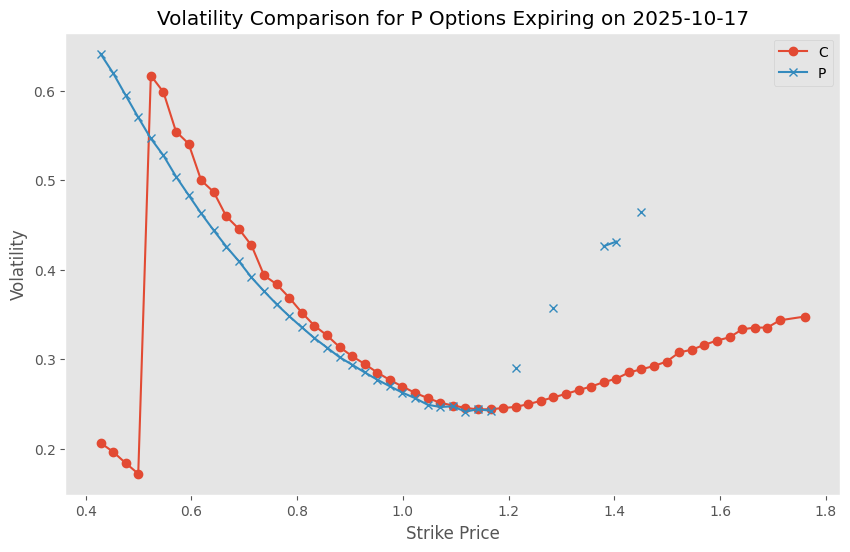

In [287]:
import matplotlib.pyplot as plt



exp = '2025-10-17'
# Specify the expiration and right
specific_expiration = exp  # Change this to your desired expiration
specific_right = 'P'  # Change this to 'C' for call or 'P' for put

# Filter the t DataFrame
filtered_chain = european_converted_chain[
    (european_converted_chain['expiration'] == exp) 
]

filtered_chain = filtered_chain.pivot_table(
    columns = 'right',
    index = 'moneyness',
    values = 'european_vols_equiv'
)


# # Sort by strike
# filtered_chain = filtered_chain.sort_values(by='moneyness')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_chain.index, filtered_chain['C'], label='C', marker='o')
plt.plot(filtered_chain.index, filtered_chain['P'], label='P', marker='x')
plt.title(f'Volatility Comparison for {specific_right} Options Expiring on {specific_expiration}')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()


In [557]:
# Filter the european_converted_chain DataFrame
filtered_chain = european_converted_chain[
    (european_converted_chain['expiration'] == specific_expiration)]
filtered_chain.to_csv("filtered_chain.csv", index=False)

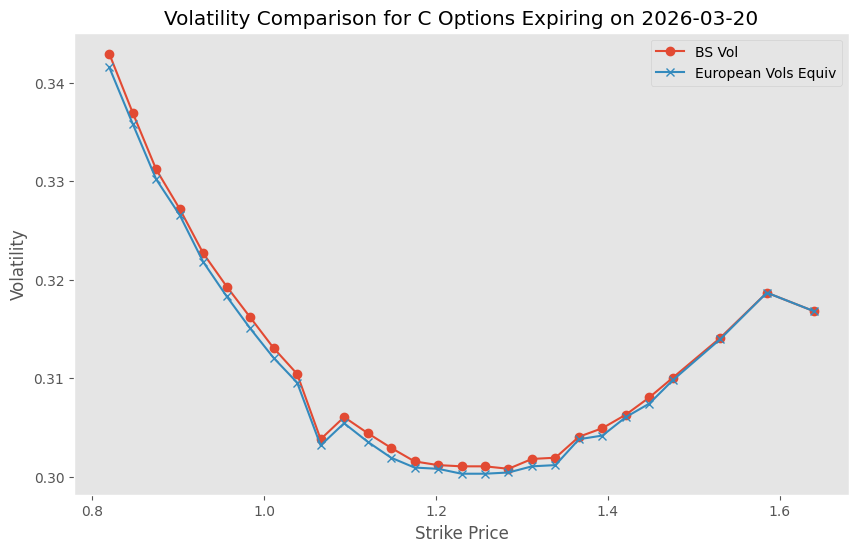

In [551]:
import matplotlib.pyplot as plt

# Specify the expiration and right
specific_expiration = exp  # Change this to your desired expiration
specific_right = 'C'  # Change this to 'C' for call or 'P' for put

# Filter the european_converted_chain DataFrame
filtered_chain = european_converted_chain[
    (european_converted_chain['expiration'] == specific_expiration) &
    (european_converted_chain['right'] == specific_right)
]

# Sort by strike
filtered_chain = filtered_chain.sort_values(by='moneyness')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_chain['moneyness'], filtered_chain['bs_vol'], label='BS Vol', marker='o')
plt.plot(filtered_chain['moneyness'], filtered_chain['european_vols_equiv'], label='European Vols Equiv', marker='x')
plt.title(f'Volatility Comparison for {specific_right} Options Expiring on {specific_expiration}')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

In [379]:
filtered_chain[['strike', 'bs_vol', 'intrinsic_value', 'midpoint']]
filtered_chain['eu_boundary'] = filtered_chain['f']-(filtered_chain['strike']/(1+ get_rates('2025-07-16')* filtered_chain['t']))
filtered_chain['restrict'] = filtered_chain['midpoint'] - filtered_chain['eu_boundary']
filtered_chain['restrict2'] = filtered_chain['midpoint'] - filtered_chain['eu_lower_bound']
filtered_chain[['midpoint','eu_boundary', 'strike', 'restrict', 'restrict2', 'eu_lower_bound', 'valuation_date']]

,midpoint,eu_boundary,strike,restrict,restrict2,eu_lower_bound,valuation_date
datetime,,,,,,,
2025-07-16,55.825,56.724555,155.0,-0.899555,0.001417,55.823583,2025-07-16 16:00:00
2025-07-16,50.850,51.745899,160.0,-0.895899,0.005073,50.844927,2025-07-16 16:00:00
2025-07-16,46.025,46.767243,165.0,-0.742243,0.158729,45.866271,2025-07-16 16:00:00
2025-07-16,41.300,41.788586,170.0,-0.488586,0.412385,40.887615,2025-07-16 16:00:00
2025-07-16,36.375,36.809930,175.0,-0.434930,0.466042,35.908958,2025-07-16 16:00:00
2025-07-16,31.525,31.831274,180.0,-0.306274,0.594698,30.930302,2025-07-16 16:00:00
2025-07-16,26.950,26.852617,185.0,0.097383,0.998354,25.951646,2025-07-16 16:00:00
2025-07-16,22.525,21.873961,190.0,0.651039,1.552011,20.972989,2025-07-16 16:00:00
2025-07-16,18.250,16.895305,195.0,1.354695,2.255667,15.994333,2025-07-16 16:00:00


In [376]:
test_valuation_date

'2025-07-16'

In [364]:
filtered_chain['midpoint'] - (((filtered_chain['f'] - filtered_chain['strike']) * np.exp(-get_rates(test_valuation_date) * filtered_chain['t'])) )

datetime
2025-07-16     0.001928
2025-07-16     0.005539
2025-07-16     0.159149
2025-07-16     0.412760
2025-07-16     0.466371
2025-07-16     0.594982
2025-07-16     0.998592
2025-07-16     1.552203
2025-07-16     2.255814
2025-07-16     3.384424
2025-07-16     5.038035
2025-07-16     7.066646
2025-07-16     9.620256
2025-07-16    12.723867
2025-07-16    16.342478
2025-07-16    20.366089
2025-07-16    24.809699
2025-07-16    29.403310
2025-07-16    34.176921
2025-07-16    39.035531
2025-07-16    43.934142
2025-07-16    48.862753
2025-07-16    53.806363
dtype: float64

In [316]:
# def atm_finder_func(x):

def get_atm_vol(chain: pd.DataFrame) -> pd.Series:
    """
    Finds the ATM volatility for a given expiration in the chain.
    Args:
        x (pd.DataFrame): The option chain DataFrame for a specific expiration.
    Returns:
        float: The ATM volatility for the given expiration.
    """
    def finder(x):
        min_l_m= abs(x['log_moneyness']).min()
        return x[x['log_moneyness'].abs() == min_l_m]['european_vols_equiv'].values[0]
    return chain.groupby('expiration').apply(finder)

def get_atm_T(chain: pd.DataFrame) -> pd.Series:
    """
    Finds the ATM time to expiration for a given expiration in the chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame for a specific expiration.
        
    Returns:
        pd.Series: The ATM time to expiration for the given expiration.
    """
    def finder(x):
        min_l_m= abs(x['log_moneyness']).min()
        return x[x['log_moneyness'].abs() == min_l_m]['t'].values[0]
    return chain.groupby('expiration').apply(finder)


atm_strike = get_atm_vol(european_converted_chain)
atm_t = get_atm_T(european_converted_chain)
atm_strike, atm_t

(expiration
 2025-07-18    0.252206
 2025-07-25    0.241333
 2025-08-01    0.327943
 2025-08-08    0.309946
 2025-08-15    0.293949
 2025-08-22    0.287825
 2025-08-29    0.279951
 2025-09-19    0.270078
 2025-10-17    0.262454
 2025-11-21    0.274952
 2025-12-19    0.267953
 2026-01-16    0.272952
 2026-02-20    0.267453
 2026-03-20    0.273077
 2026-05-15    0.275077
 2026-06-18    0.269703
 2026-09-18    0.273702
 2026-12-18    0.273077
 2027-01-15    0.273327
 2027-06-17    0.273452
 2027-12-17    0.257955
 dtype: float64,
 expiration
 2025-07-18    0.005476
 2025-07-25    0.024641
 2025-08-01    0.043806
 2025-08-08    0.062971
 2025-08-15    0.082136
 2025-08-22    0.101300
 2025-08-29    0.120465
 2025-09-19    0.177960
 2025-10-17    0.254620
 2025-11-21    0.350445
 2025-12-19    0.427105
 2026-01-16    0.503765
 2026-02-20    0.599589
 2026-03-20    0.676249
 2026-05-15    0.829569
 2026-06-18    0.922656
 2026-09-18    1.174538
 2026-12-18    1.423682
 2027-01-15    1.500342

In [87]:
refined_chains = {}
for tick in chains:
    refined_chains[tick] = confine_chain_with_pricing_config(chains[tick])

sample_refined_chain = refined_chains['AAPL']
len(sample_refined_chain), len(sample_chain)

(1632, 2428)

In [16]:
from trade.helpers.Logging import setup_logger
logger =setup_logger('SSVIModel')


def get_expected_column(col, 
                        chain:pd.DataFrame,
                        valuation_date:str=None,
                        div_type:str='discrete'):
    """
    Retrieves the expected column value for a given option chain.
    Args:

        col (str): The column to retrieve ('f', 't', 'div_schedule', 'spot').
        chain (pd.DataFrame): The option chain DataFrame.
        valuation_date (str): The date of valuation.
        div_type (str): Type of dividend ('discrete' or 'continuous').
    Returns:
        float or pd.Series: The expected value for the specified column.
    """
    if col == 'f':
        return get_forward_price_on_chain(
            chain,
            valuation_date,
            get_rates(valuation_date),
            div_type=div_type
        )
    elif col == 't':
        return chain['expiration'].apply(
            lambda x: time_distance_helper(
                x,
                valuation_date,
            )
        ).astype(float)
    elif col == 'div_schedule':
        return get_dividend_schedule_on_chain(
            chain,
            valuation_date
        )
    elif col == 'spot':
        return get_spot(chain['root'].iloc[0], valuation_date)
    


def validate_chain_columns(
                            chain: pd.DataFrame,
                            valuation_date: str,
                            required_columns: list = None,
                            expected_columns: list = None,
                            div_type: str = 'discrete') -> pd.DataFrame    :
    """
    Validates that the required columns are present in the chain DataFrame.
    Raises ValueError if any required column is missing.
    """
    # Ensure chain is formatted
    chain=format_chain(chain)
    chain=confine_chain_with_pricing_config(chain)
    chain['valuation_date'] = valuation_date 
    
    # Define required columns based on the model
    if required_columns is None:
        required_columns = ['expiration', 'strike', 'right', 'midpoint', 'f', 'spot']

    ## Check for required columns
    for col in required_columns:
        if col not in chain.columns.str.lower():
            raise ValueError(f"Missing required column: {col} in chain DataFrame")
    
    # Check for optional columns and fill them if missing
    if expected_columns is None:
        expected_columns = ['t']
    for col in expected_columns:
        if col not in chain.columns.str.lower():
            # If the column is missing, we will fill it with default values
            if col=='spot': assert 'root' in chain.columns.str.lower(), \
                "Missing 'root' column in chain DataFrame for spot price retrieval"
            logger.warning(f"Column {col} is missing in the chain DataFrame. Filling with default values.")
            chain[col] = get_expected_column(col,
                                             chain=chain,
                                             valuation_date=valuation_date,
                                             div_type=div_type)

    
    chain.columns = chain.columns.str.lower()  # Normalize column names to lowercase
    chain['moneyness']= chain['strike'] / chain['spot']
    chain['log_moneyness'] = np.log(chain['moneyness'])
    chain['fwd_moneyness']= chain['f'] / chain['strike']
    chain['dte'] = chain['t'] * DAILY_BASIS  # Convert T to DTE
    call_chain = chain[chain['right'].str.lower() == 'c'].copy()
    put_chain = chain[chain['right'].str.lower() == 'p'].copy()
    return call_chain, put_chain, chain
        


def calculate_vol(
        chain: pd.DataFrame,
        valuation_date: str,
        N: int = 250,
        model: str = 'binomial',
):
    
    if 'vol' not in chain.columns.str.lower():
        logger.info("Calculating implied volatility for the option chain. Model is set to '%s'.", model)
        if model == 'bs':
            # Use Black-Scholes model for volatility estimation
            chain['vol'] = get_bs_vol_on_chain(chain, valuation_date)

        elif model == 'binomial':
            # Use Binomial model for volatility estimation
            chain['vol'] = get_discrete_crr_vol_on_chain(chain, valuation_date, N=N)
    return chain



## SSVI 

In [17]:
import numpy as np
from typing import List, Tuple, Callable
import math
from trade.helpers.pools import runProcesses

# -------------------------------------------------
# 1. Black-Scholes Call price       (no SciPy need)
# -------------------------------------------------
def normal_cdf(x):                       # Φ(x)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def bs_call_price(spot, strike, maturity, rate, vol):
    """Black-Scholes European call."""
    if vol <= 0 or maturity <= 0:
        return max(0.0, spot - strike)
    d1 = (math.log(spot / strike) + (rate + 0.5 * vol**2) * maturity) / (vol * math.sqrt(maturity))
    d2 = d1 - vol * math.sqrt(maturity)
    return (spot * normal_cdf(d1) -
            strike * math.exp(-rate * maturity) * normal_cdf(d2))

# -------------------------------------------------
# 2. SSVI helpers
# -------------------------------------------------
def atm_total_variance(t, var0, var_inf, kappa):
    """
    θ(t)  = ((var0 - var_inf)*(1 - e^{-κ t})/(κ t) + var_inf) * t
    """
    return ((var0 - var_inf) * (1 - np.exp(-kappa * t))
            / (kappa * t) + var_inf) * t

def skew_phi(theta_t, eta, lam):
    return eta * theta_t ** lam

def ssvi_total_variance(log_moneyness, theta_t, eta, lam, rho):
    phi_val = skew_phi(theta_t, eta, lam)
    term1   = rho * phi_val * log_moneyness
    term2   = np.sqrt((phi_val * log_moneyness + rho)**2 + 1 - rho**2)
    return 0.5 * theta_t * (1 + term1 + term2)

def ssvi_implied_vol(fwd, strike, maturity,
                     var0, var_inf, kappa,
                     eta, lam, rho):
    """Return σ implied by SSVI."""
    k = np.log(strike / fwd)                    # log-moneyness
    theta_t = atm_total_variance(maturity, var0, var_inf, kappa)
    total_var = ssvi_total_variance(k, theta_t, eta, lam, rho)
    return np.sqrt(total_var / maturity)

def make_candidate(bounds: List[Tuple[float, float]], iterations) -> np.ndarray:
    """
    Generate a random candidate solution within the given bounds.
    bounds: list of (low, high) for each dimension
    """
    rng = np.random.default_rng(42)
    low  = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])

    # (iterations, d) matrix of uniform random samples
    candidates = low + (high - low) * rng.random((iterations, len(bounds)))
    return candidates


def random_search_vec(objective_multi: Callable[[np.ndarray], np.ndarray],
                      bounds: List[Tuple[float, float]],
                      iterations: int = 40_000) -> Tuple[np.ndarray, float]:
    """
    Vectorised random search.
    objective_multi: accepts an (N, d) array -> returns (N,) array of losses
    bounds         : list of (low, high) for each dimension
    iterations     : how many random draws
    """

    # vectorised loss evaluation -> (iterations,)
    candidates = make_candidate(bounds, iterations)
    losses = objective_multi(candidates)

    best_idx = np.argmin(losses)
    return candidates[best_idx], losses[best_idx]


def atm_loss_multi(X, t, iv_atm):
    """
    X : (N, 3)  – rows = [var0, var_inf, kappa]
    t, iv_atm   – market ATM maturities and vols (1-D)
    returns     – loss for each row  (shape (N,))
    """
    var0, var_inf, kappa = X[:, 0], X[:, 1], X[:, 2]
    theta_t  = atm_total_variance(t[:, None], var0, var_inf, kappa)  # broadcast
    model_iv = np.sqrt(theta_t / t[:, None])
    mse      = ((model_iv - iv_atm[:, None])**2).mean(axis=0)        # → (N,)

    # guard against NaN / huge vols
    invalid   = (np.isinf(mse)) | (np.isnan(mse))
    mse = np.where(invalid, 1e4, mse)  # penalise
    return mse

def surface_loss_multi(params_mat,
                       K_grid, T_grid, fwd,
                       var0_hat, var_inf_hat, kappa_hat,
                       market_iv):
    """
    params_mat : shape (N, 3) – each row [eta, lambda, rho]
    returns    : shape (N,)   – MSE per candidate
    """
    eta, lam, rho = params_mat.T                      # (N,)

    # ---- hard bounds to avoid overflow -----------------------------------
    bad = (eta <= 0) | (lam <= -0.9) | (lam >= 1.0) | (np.abs(rho) >= 0.999)
    # mark bad rows; they get a huge constant loss later
    safe_eta = np.where(bad, 1.0, eta)               # (N,)
    safe_lam = np.where(bad, 0.0, lam)
    safe_rho = np.where(bad, 0.0, rho)

    # ---- broadcast market grid (M,1) with candidates (1,N) --------------
    k  = np.log(K_grid / fwd)[:, None]                # (M,1)
    T  = T_grid[:, None]                              # (M,1)
    theta = atm_total_variance(T, var0_hat, var_inf_hat, kappa_hat)

    # each safe_* is (N,) so reshape to (1,N) for broadcasting
    total_var = ssvi_total_variance(
        k, theta,
        safe_eta[None, :], safe_lam[None, :], safe_rho[None, :]
    )                                                 # → (M,N)

    iv_model = np.sqrt(total_var / T)                 # (M,N)

    # ---- guard against any residual NaN / huge vols ----------------------
    invalid = (~np.isfinite(iv_model)) | (iv_model > 5)   # 500 % vol cutoff
    iv_model = np.where(invalid, 1e4, iv_model)           # penalise

    mse = np.mean((iv_model - market_iv[:, None])**2, axis=0)  # (N,)


    # slam the rows we flagged as ‘bad’
    mse = np.where(bad, 1e9, mse)
    return mse





In [18]:
def _loss_chunk_with_idx(idx,
                         params_chunk,
                         K_grid, T_grid, fwd,
                         var0_hat, var_inf_hat, kappa_hat,
                         market_iv):
    # Call your original function on a chunk
    mse = surface_loss_multi(params_chunk,
                             K_grid, T_grid, fwd,
                             var0_hat, var_inf_hat, kappa_hat,
                             market_iv)
    return idx, mse  # keep index so we can reassemble in order


def surface_loss_multi_parallel(params_mat,
                                K_grid, T_grid, fwd,
                                var0_hat, var_inf_hat, kappa_hat,
                                market_iv,
                                *,
                                chunk_size=1024,
                                run_type='imap'):
    """
    Parallel wrapper around surface_loss_multi using runProcesses.
    params_mat: (N,3) -> returns (N,)
    No globals; constants are passed to each worker.
    """
    N = int(params_mat.shape[0])
    if N == 0:
        return np.empty((0,), dtype=float)

    # 1) Make chunks
    chunks = [params_mat[i:min(i+chunk_size, N)] 
              for i in range(0, N, chunk_size)]
    idxs   = list(range(len(chunks)))
    n      = len(chunks)

    # 2) Build OrderedInputs for your runProcesses(func, [args1, args2, ...])
    OrderedInputs = [
        idxs,
        chunks,
        [K_grid]      * n,
        [T_grid]      * n,
        [fwd]         * n,
        [var0_hat]    * n,
        [var_inf_hat] * n,
        [kappa_hat]   * n,
        [market_iv]   * n,
    ]

    # 3) Fan out
    results = runProcesses(_loss_chunk_with_idx, OrderedInputs, run_type=run_type)

    # 4) Materialize depending on run_type
    if run_type == 'amap':              # async ordered
        results = results.get()
    elif run_type in ('imap', 'uimap'): # iterator / unordered
        results = list(results)

    # 5) Reassemble in original order of rows
    results.sort(key=lambda x: x[0])                 # by chunk index
    mse_chunks = [m for _, m in results]
    return np.concatenate(mse_chunks, axis=0)


In [20]:
PRICING_CONFIG['ATM_WIDTH'] =0.05

In [21]:
PRICING_CONFIG

{'INTRADAY_AGG': '5m',
 'MARKET_OPEN_TIME': '09:30',
 'MARKET_CLOSE_TIME': '16:00',
 'AVAILABLE_PRICING_MODELS': ['bs', 'binomial', 'mc'],
 'AVAILABLE_INTERVALS': ['h', 'd', 'w', 'q', 'y', 'M', 'm'],
 'AVAILABLE_GREEKS': ['vega',
  'vanna',
  'volga',
  'delta',
  'gamma',
  'theta',
  'rho'],
 'UPPER_BOUND_MONEYNESS': 1.2,
 'LOWER_BOUND_MONEYNESS': 0.8,
 'DAYS_IN_MONTH': 30,
 'DAYS_IN_YEAR': 360,
 'MIN_BAR_TIME_INTERVAL': '5m',
 'QUOTE_DATA_START_TIME': '9:45:00',
 'VOL_SURFACE_WIDTH': 0.8,
 'VOL_SURFACE_MIN_DTE_THRESHOLD': 30,
 'VOL_SURFACE_MAX_DTE_THRESHOLD': 732,
 'ATM_WIDTH': 0.05,
 'VOL_SURFACE_SURFACE_LOSS_THRESHOLD': 0.1,
 'VOL_SURFACE_ATM_LOSS_THRESHOLD': 0.05,
 'DEFAULT_SSVI_PARAMS_ITERATION': 25000}

In [22]:
atm_iv ={}
atm_T={}

def get_atm_T_vols_on_chain(
        chain:pd.DataFrame
) -> pd.Series:
    """
    Retrieves the ATM implied volatilities for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        valuation_date (str): The date of valuation.
        
    Returns:
        pd.Series: The ATM implied volatilities for the option chain.
    """
    return chain[chain['moneyness'].between(1-PRICING_CONFIG['ATM_WIDTH'], 
                                            1+PRICING_CONFIG['ATM_WIDTH'])]['vol'].values

def get_atm_T_maturities_on_chain(
        chain:pd.DataFrame
) -> pd.Series:
    """
    Retrieves the ATM maturities for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        pd.Series: The ATM maturities for the option chain.
    """
    if 'T' in chain.columns:
        chain['t']= chain['T']
        
    return chain[chain['moneyness'].between(1-PRICING_CONFIG['ATM_WIDTH'], 
                                            1+PRICING_CONFIG['ATM_WIDTH'])]['t'].values

for tick in refined_chains:
    print(f"Calculating ATM T and vol for {tick} on {test_valuation_date}")
    atm_iv[tick] = get_atm_T_vols_on_chain(chains[tick])
    atm_T[tick] = get_atm_T_maturities_on_chain(chains[tick])
    print(f"Done for {tick} on {test_valuation_date}")

Calculating ATM T and vol for AAPL on 2025-07-16
Done for AAPL on 2025-07-16
Calculating ATM T and vol for MSFT on 2025-07-16
Done for MSFT on 2025-07-16
Calculating ATM T and vol for GOOGL on 2025-07-16
Done for GOOGL on 2025-07-16
Calculating ATM T and vol for AMZN on 2025-07-16
Done for AMZN on 2025-07-16
Calculating ATM T and vol for TSLA on 2025-07-16
Done for TSLA on 2025-07-16


In [23]:
params={}
def get_best_params(T_atm: List[float],
                    iv_atm: List[float]) -> Tuple[np.ndarray, float]:
    """
    Find the best parameters for the ATM term structure.
    Returns:
        var0_hat, var_inf_hat, kappa_hat
    """
    bounds = [(1e-4, 0.2), # var0: Min ATM Variance across DTE
              (1e-4, 0.2), # var_inf_hat: Max ATM Variance across DTE
              (0.05, 3.0)] # kappa: Speed from var0 to var_inf_hat
    best_params, best_loss = random_search_vec(
        lambda X: atm_loss_multi(X, T_atm, iv_atm),
        bounds,
        iterations=3000
    )
    return best_params, best_loss


# best_params, best_loss = get_best_params()
# var0_hat, var_inf_hat, kappa_hat = best_params
# print("best", best_params, "loss", best_loss)

for tick in refined_chains:
    print(f"Calculating best params for {tick} on {test_valuation_date}")
    (var0_hat, var_inf_hat, kappa_hat), atm_loss = get_best_params(
        atm_T[tick],
        atm_iv[tick]
    )
    params[tick] = {
        'var0_hat': var0_hat,
        'var_inf_hat': var_inf_hat,
        'kappa_hat': kappa_hat,
        'atm_loss': atm_loss
    }

    print(f"Done for {tick} on {test_valuation_date}")
params

Calculating best params for AAPL on 2025-07-16
Done for AAPL on 2025-07-16
Calculating best params for MSFT on 2025-07-16
Done for MSFT on 2025-07-16
Calculating best params for GOOGL on 2025-07-16
Done for GOOGL on 2025-07-16
Calculating best params for AMZN on 2025-07-16
Done for AMZN on 2025-07-16
Calculating best params for TSLA on 2025-07-16
Done for TSLA on 2025-07-16


{'AAPL': {'var0_hat': 0.08300936940997879,
  'var_inf_hat': 0.06550145460933357,
  'kappa_hat': 2.90959397166083,
  'atm_loss': 0.0006028864626750488},
 'MSFT': {'var0_hat': 0.05214367382870849,
  'var_inf_hat': 0.0645658391494492,
  'kappa_hat': 0.7653244164335816,
  'atm_loss': 0.001695821106932738},
 'GOOGL': {'var0_hat': 0.15622857816972924,
  'var_inf_hat': 0.067951107265773,
  'kappa_hat': 2.837984186845636,
  'atm_loss': 0.0022094514483511508},
 'AMZN': {'var0_hat': 0.10413944300906883,
  'var_inf_hat': 0.09278877536483207,
  'kappa_hat': 2.0858739702564564,
  'atm_loss': 0.0012366408505716836},
 'TSLA': {'var0_hat': 0.19908227140274562,
  'var_inf_hat': 0.19380147408874504,
  'kappa_hat': 0.7020154721352964,
  'atm_loss': 0.014546646015758702}}

In [24]:
k_grid = {}
t_grid = {}
market_iv_grid= {}
fwd_grid= {}

def get_K_grid(chain:pd.DataFrame) -> np.ndarray:
    """
    Retrieves the strike prices from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        np.ndarray: The strike prices for the option chain.
    """
    return chain['strike'].values

def get_T_grid(chain:pd.DataFrame) -> np.ndarray:
    """
    Retrieves the maturities from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        np.ndarray: The maturities for the option chain.
    """
    return chain['t'].values

def get_market_iv_grid(chain:pd.DataFrame) -> np.ndarray:
    """
    Retrieves the market implied volatilities from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        np.ndarray: The market implied volatilities for the option chain.
    """
    return chain['vol'].values

def get_fwd_grid(chain:pd.DataFrame) -> float:
    """
    Retrieves the forward price from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        float: The forward price for the option chain.
    """
    return chain['f'].iloc[0]  # Assuming F is constant across the chains


for tick in refined_chains:
    print(f"Calculating K, T, market IV and F for {tick} on {test_valuation_date}")
    k_grid[tick] = get_K_grid(refined_chains[tick])
    t_grid[tick] = get_T_grid(refined_chains[tick])
    market_iv_grid[tick] = get_market_iv_grid(refined_chains[tick])
    fwd_grid[tick] = get_fwd_grid(refined_chains[tick])
    print(f"Done for {tick} on {test_valuation_date}")

Calculating K, T, market IV and F for AAPL on 2025-07-16
Done for AAPL on 2025-07-16
Calculating K, T, market IV and F for MSFT on 2025-07-16
Done for MSFT on 2025-07-16
Calculating K, T, market IV and F for GOOGL on 2025-07-16
Done for GOOGL on 2025-07-16
Calculating K, T, market IV and F for AMZN on 2025-07-16
Done for AMZN on 2025-07-16
Calculating K, T, market IV and F for TSLA on 2025-07-16
Done for TSLA on 2025-07-16


In [25]:

def get_surface_params(
        k_grid: np.ndarray,
        t_grid: np.ndarray,
        fwd_grid: float,
        var0_hat: float,
        var_inf_hat: float,
        kappa_hat: float,
        market_iv_grid: np.ndarray,
        iterations: int = 50_000,
        chunk_size: int = None
) -> Tuple[float, float, float, float]:
        """
        Estimate the SSVI surface parameters (eta, lambda, rho) using random search.
        Args:
        k_grid (np.ndarray): The strike prices.
        t_grid (np.ndarray): The maturities.
        fwd_grid (float): The forward price.
        var0_hat (float): Estimated initial variance.
        var_inf_hat (float): Estimated long-term variance.
        kappa_hat (float): Estimated speed of mean reversion.
        market_iv_grid (np.ndarray): Market implied volatilities.
        iterations (int): Number of random search iterations.
        chunk_size (int): Size of chunks for parallel processing.
        Returns:
        Tuple[float, float, float, float]: Estimated parameters (eta, lambda, rho) and best loss.
        """
        if chunk_size is None:
            chunk_size = int(iterations / 8)

        # 1️⃣ tighter parameter bounds
        surf_bounds = [(0.05, 1.5),      # eta
                        (-0.8, 0.8),      # lambda
                        (-0.95, 0.95)]    # rho


        surface_lamba = lambda X: surface_loss_multi_parallel(X, K_grid=k_grid, 
                                                        T_grid=t_grid,
                                                        fwd=fwd_grid,
                                                        var0_hat=var0_hat,
                                                        var_inf_hat=var_inf_hat,
                                                        kappa_hat=kappa_hat,
                                                        market_iv=market_iv_grid,
                                                        chunk_size=chunk_size)
        (eta_hat, lambda_hat, rho_hat), best_loss = random_search_vec(surface_lamba,
                                                                surf_bounds, iterations)

        return eta_hat, lambda_hat, rho_hat, best_loss



In [26]:
for tick in refined_chains:
    print(f"Calculating surface params for {tick} on {test_valuation_date}")
    eta_hat, lambda_hat, rho_hat, best_loss = get_surface_params(
        k_grid[tick],
        t_grid[tick],
        fwd_grid[tick],
        params[tick]['var0_hat'],
        params[tick]['var_inf_hat'],
        params[tick]['kappa_hat'],
        market_iv_grid[tick]
    )
    params[tick].update({
        'eta_hat': eta_hat,
        'lambda_hat': lambda_hat,
        'rho_hat': rho_hat,
        'surface_loss': best_loss
    })
    print(f"Done for {tick} on {test_valuation_date}")

Calculating surface params for AAPL on 2025-07-16
Done for AAPL on 2025-07-16
Calculating surface params for MSFT on 2025-07-16
Done for MSFT on 2025-07-16
Calculating surface params for GOOGL on 2025-07-16
Done for GOOGL on 2025-07-16
Calculating surface params for AMZN on 2025-07-16
Done for AMZN on 2025-07-16
Calculating surface params for TSLA on 2025-07-16
Done for TSLA on 2025-07-16


In [27]:
def calculate_normalized_rmse_loss(
        market_iv: np.ndarray,
        model_iv: np.ndarray,
        moneyness: np.ndarray,
) -> Tuple[float, float, float]:
    
    """
    Calculate the normalized loss between market and model implied volatilities.
    
    Args:
        market_iv (np.ndarray): Market implied volatilities.
        model_iv (np.ndarray): Model implied volatilities.
        moneyness (np.ndarray): Moneyness values.
        
    Returns:
        Tuple[float, float, float]: Normalized median loss, right wing loss, left wing loss.
    """
    
    ## Normalized Median
    median_iv = np.median(market_iv)
    normalized_median_loss = np.sqrt(np.mean((market_iv - model_iv)**2)) / median_iv

    ## Right Wing Loss (> 1.0)
    right_wing_mask = moneyness > 1.0
    median_right_wing_iv = np.median(market_iv[right_wing_mask])
    right_wing_loss = np.sqrt(np.mean(
        (market_iv[right_wing_mask] - model_iv[right_wing_mask]) **2)) / median_right_wing_iv

    ## Left Wing Loss (< 1.0)
    left_wing_mask = moneyness < 1.0
    median_left_wing_iv = np.median(market_iv[left_wing_mask])
    left_wing_loss = np.sqrt(np.mean(
        (market_iv[left_wing_mask] - model_iv[left_wing_mask])**2)) / median_left_wing_iv

    return normalized_median_loss, right_wing_loss, left_wing_loss



In [28]:
def calculate_normalized_mae_loss(
        market_iv: np.ndarray,
        model_iv: np.ndarray,
        moneyness: np.ndarray
) -> Tuple[float, float, float]:
    """
    Calculate the normalized mean absolute error (MAE) loss between market and model implied volatilities.
    
    Args:
        market_iv (np.ndarray): Market implied volatilities.
        model_iv (np.ndarray): Model implied volatilities.
        moneyness (np.ndarray): Moneyness values.
        
    Returns:
        Tuple[float, float, float]: Normalized median MAE loss, right wing MAE loss, left wing MAE loss.
    """
    
    ## Normalized Median
    median_iv = np.median(market_iv)
    normalized_median_mae_loss = np.mean(np.abs(market_iv - model_iv)) / median_iv

    ## Right Wing Loss (> 1.0)
    right_wing_mask = moneyness > 1.0
    median_right_wing_iv = np.median(market_iv[right_wing_mask])
    right_wing_mae_loss = np.mean(
        np.abs(market_iv[right_wing_mask] - model_iv[right_wing_mask])) / median_right_wing_iv

    ## Left Wing Loss (< 1.0)
    left_wing_mask = moneyness < 1.0
    median_left_wing_iv = np.median(market_iv[left_wing_mask])
    left_wing_mae_loss = np.mean(
        np.abs(market_iv[left_wing_mask] - model_iv[left_wing_mask])) / median_left_wing_iv

    return normalized_median_mae_loss, right_wing_mae_loss, left_wing_mae_loss

In [29]:
## DATE UTILS

from dbase.DataAPI.ThetaData import (
    extract_numeric_value)
from datetime import date, datetime


def identify_length_for_model(string, integer) -> int:
    """
    
    Identify the length of the timeframe in minutes based on the string and integer provided.
    Parameters
    
    ----------
    string : str
        The string representing the timeframe (e.g., 'm', 'd', 'w', 'y').
    integer : int
    The integer representing the number of units for the timeframe.
    Returns
    -------
    int
        The length of the timeframe in minutes.
    
    """

    TIMEFRAMES_VALUES = {'d': 1, 'w': 7, 'm': 30, 'y': DAILY_BASIS}
    assert string in TIMEFRAMES_VALUES.keys(
    ), f'Available timeframes are {TIMEFRAMES_VALUES.keys()}, recieved "{string}"'
    return integer * TIMEFRAMES_VALUES[string]

def convert_date_to_time_to_maturity(dt: str,
                                     valuation_date: str = None) -> float:
    """
    Converts a date to time to maturity in years.
    
    Args:
        dt (datetime): The date to convert.
            example: '3m', '2025-08-08', 1
        
    Returns:
        float: Time to maturity in years.
    """

    ## If dt is a string, check if it is a date or a duration
    if isinstance(dt, (str, pd.Timestamp, datetime, date)):
        try:
            # Try to parse as a date first
            dt = pd.to_datetime(dt)
            assert valuation_date is not None, "valuation_date must be provided if dt is a date string"
            valuation_date = pd.to_datetime(valuation_date)
            dt = (dt - valuation_date).days
        except ValueError:
            # If it fails, assume it's a duration
            dt = identify_length_for_model(*extract_numeric_value(dt))
            if dt is None:
                raise ValueError(f"Invalid date or duration format: {dt}")
    elif isinstance(dt, (float,int)):
        # If dt is a number, assume it's a duration in days
        dt = float(dt)
    elif isinstance(dt, pd.Timedelta):
        # If dt is a timedelta, convert it to days
        dt = dt.days

    else:
        raise ValueError(f"Unsupported type for dt: {type(dt)}. Expected str, int, float, datetime, or pd.Timedelta.")

    assert_dt_within_range(dt)
    return dt/DAILY_BASIS

def assert_dt_within_range(dt: float):
    """
    Asserts that the time to maturity is within the range defined by PRICING_CONFIG.
    
    Args:
        dt (float): The time to maturity in years.
        
    Raises:
        ValueError: If dt is not within the configured range.
    """
    if not (PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD'] <= dt <= PRICING_CONFIG['VOL_SURFACE_MAX_DTE_THRESHOLD']):
        raise ValueError(f"Time to maturity {dt} is out of bounds. "
                         f"Must be between {PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD']} and {PRICING_CONFIG['VOL_SURFACE_MAX_DTE_THRESHOLD']}.")

convert_date_to_time_to_maturity('3m')

0.2464065708418891

In [30]:
## Strike Convert Utils

def assert_k_bounds_model_range(k: list | np.ndarray,
                                f: float) -> None:
    """
    Asserts that the strikes are within the bounds defined by PRICING_CONFIG.
    Args:
        k (list or np.ndarray): List of strikes.
    Raises:
        ValueError: If any strike is not within the configured bounds.
    """
    k = np.array(k, dtype=float)
    if not np.all((k >= f * (1 - PRICING_CONFIG['VOL_SURFACE_WIDTH'])) &
                    (k <= f * (1 + PRICING_CONFIG['VOL_SURFACE_WIDTH']))):
            raise ValueError(f"Strikes {k} are out of bounds. "
                             f"Must be between {f * (1 - PRICING_CONFIG['VOL_SURFACE_WIDTH'])} and {f * (1 + PRICING_CONFIG['VOL_SURFACE_WIDTH'])}.")

def handle_strikes(
    k: list| np.ndarray,
    f: list| float, 
    strike_type: Literal['p', 'k', 'pf', 'f'],
    spot: float = None
) -> np.ndarray:
    """
    Convert strikes based on the specified strike type.
    Since SSVI model takes strikes values as absolute values, this function converts the strikes
    
    Args:
        k (list or np.ndarray): List of strikes.
        f (list or float): Forward price.
        strike_type (str): Type of strike ('p', 'k', 'pf', 'f').
        
    Returns:
        np.ndarray: Converted strikes.
    """
    k = np.array(k, dtype=float)
    if strike_type == 'p': ## Percent of spot to fwd_grid
        if spot is None:
            raise ValueError("Spot price must be provided for 'p' strike type.")
        
        strikes= k * spot
    elif strike_type == 'k': ## Strike to fwd_grid
        strikes= k
    elif strike_type == 'pf': ## Percent of fwd_grid
        strikes= k * f
    elif strike_type == 'f': ## Forward price
        strikes ## It is expected that strike passed is forward price strike
    else:
        raise ValueError(f"Invalid strike type: {strike_type}")
    assert_k_bounds_model_range(strikes, f)
    return strikes



In [31]:
from dataclasses import dataclass, field
from pydantic import BaseModel, Field, ConfigDict
from pydantic.dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List, Tuple, Literal
from scipy.interpolate import interp1d
from trade.helpers.Logging import setup_logger
logger =setup_logger('SSVIModel')

@dataclass
class SSVIModelParams:
    """
    SSVI Model Parameters for the Stochastic Volatility Surface.
    This class holds the parameters for the SSVI model, including the ATM variance, 
    long-term variance, speed of mean reversion, skewness, kurtosis, and correlation.
    Attributes:
        var0_hat (float): Initial variance estimate at ATM.
        var_inf_hat (float): Long-term variance estimate.
        kappa_hat (float): Speed of mean reversion.
        eta_hat (float): Skewness parameter.
        lambda_hat (float): Kurtosis parameter.
        rho_hat (float): Correlation parameter.
        atm_loss (float): Loss associated with the ATM volatility estimation.
        surface_loss (float): Loss associated with the surface fitting.
    """
    var0_hat: float = Field(default=0.0, description="Initial variance estimate at ATM")
    var_inf_hat: float = Field(default=0.0, description="Long-term variance estimate")
    kappa_hat: float = Field(default=0.0, description="Speed of Mean Reversion")
    eta_hat: float = Field(default=0.0, description="Skewness parameter")
    lambda_hat: float = Field(default=0.0, description="Kurtosis parameter")
    rho_hat: float = Field(default=0.0, description="Correlation parameter")
    atm_loss: float = Field(default=0.0, description="Loss associated with ATM volatility estimation")
    surface_loss: float = Field(default=0.0, description="Loss associated with surface fitting")
    nrmse: float = Field(default=0.0, description="Normalized Mean Squared Error")
    rw_nrmse: float = Field(default=0.0, description="Right Wing Normalized Mean Squared Error")
    lw_nrmse: float = Field(default=0.0, description="Left Wing Normalized Mean Squared Error")
    nmae: float = Field(default=0.0, description="Normalized Mean Absolute Error")
    rw_nmae: float = Field(default=0.0, description="Right Wing Normalized Mean Absolute Error")
    lw_nmae: float = Field(default=0.0, description="Left Wing Normalized Mean Absolute Error")
    
    def __repr__(self):
        acceptable_fields = ['var0_hat', 'var_inf_hat', 'kappa_hat',
                                'eta_hat', 'lambda_hat', 'rho_hat',
                                'atm_loss', 'surface_loss']
        params = {field: getattr(self, field) for field in acceptable_fields}
        return (f"SSVIModelParams{params}\n")
    

In [32]:
## Right Picking Util

def _sigmoid_func(k: np.ndarray, 
                  f: float) -> np.ndarray:
    x = np.log(k/f)
    return 1/(1 + np.exp(4*x))

def pick_params(call_params: SSVIModelParams,
                put_params: SSVIModelParams,
                right: str) -> SSVIModelParams:
    """
    Pick parameters based on the option type (call or put).
    
    Args:
        call_params (SSVIModelParams): Parameters for call options.
        put_params (SSVIModelParams): Parameters for put options.
        right (str): The option type ('c' for call, 'p' for put).
        
    Returns:
        SSVIModelParams: The selected parameters based on the option type.
    """
    if right.lower() == 'c':
        return call_params
    elif right.lower() == 'p':
        return put_params
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c' or 'p'.")
    
def predict_vol(
    k: float,
    t: float,
    f: float,
    right: str,
    call_params: SSVIModelParams,
    put_params: SSVIModelParams
) -> float:
    """
    Predict the volatility using the SSVI model parameters.
    
    Args:
        k (float): Strike price.
        t (float): Time to maturity in years.
        f (float): Forward price.
        params (SSVIModelParams): The SSVI model parameters.
        
    Returns:
        float: The predicted volatility.
    """
    if right in ['c', 'p']:
        params = pick_params(call_params, put_params, right)
    elif right in ['itm', 'otm']:
        call_vols =  predict_vol(k, t, f, 'c', call_params, put_params)
        put_vols = predict_vol(k, t, f, 'p', call_params, put_params)
        w = _sigmoid_func(k, f)
        if right == 'itm': ## Left: Call, Right: Put
            return w * call_vols + (1 - w) * put_vols
        else:
            return (1 - w) * call_vols + w * put_vols
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c', 'p', 'itm', or 'otm'.")

    return ssvi_implied_vol(
        fwd=f, strike=k, maturity=t,
        var0=params.var0_hat, var_inf=params.var_inf_hat, kappa=params.kappa_hat,
        eta=params.eta_hat, lam=params.lambda_hat, rho=params.rho_hat
    )

In [33]:
def build_svi_params_obj(
        chain: pd.DataFrame,
        var0_hat: float,
        var_inf_hat: float,
        kappa_hat: float,
        eta_hat: float,
        lambda_hat: float,
        rho_hat: float,
        atm_loss: float,
        surface_loss: float,
) -> SSVIModelParams:
    
    """
    Build an SSVIModelParams object from the given parameters.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        var0_hat (float): Initial variance estimate at ATM.
        var_inf_hat (float): Long-term variance estimate.
        kappa_hat (float): Speed of mean reversion.
        eta_hat (float): Skewness parameter.
        lambda_hat (float): Kurtosis parameter.
        rho_hat (float): Correlation parameter.
        atm_loss (float): Loss associated with ATM volatility estimation.
        surface_loss (float): Loss associated with surface fitting.
        
    Returns:
        SSVIModelParams: The SSVI model parameters object.
    """
    ## Calculate normalized losses
    moneyness = chain['moneyness'].values
    market_iv = chain['vol'].values
    model_iv = ssvi_implied_vol(
        fwd=get_fwd_grid(chain),
        strike=get_K_grid(chain),
        maturity= get_T_grid(chain),
        var0=var0_hat, var_inf=var_inf_hat, kappa=kappa_hat,
        eta=eta_hat, lam=lambda_hat, rho=rho_hat
    )

    normalized_nrmse, rw_nrmse, lw_nrmse = calculate_normalized_rmse_loss(
        market_iv=market_iv,
        model_iv=model_iv,
        moneyness=moneyness
    )
    normalized_nmae, rw_nmae, lw_nmae = calculate_normalized_mae_loss(
        market_iv=market_iv,
        model_iv=model_iv,
        moneyness=moneyness
    )
    return SSVIModelParams(
        var0_hat=var0_hat,
        var_inf_hat=var_inf_hat,
        kappa_hat=kappa_hat,
        eta_hat=eta_hat,
        lambda_hat=lambda_hat,
        rho_hat=rho_hat,
        atm_loss=atm_loss,
        surface_loss=surface_loss,
        nrmse=normalized_nrmse,
        rw_nrmse=rw_nrmse,
        lw_nrmse=lw_nrmse,
        nmae=normalized_nmae,
        rw_nmae=rw_nmae,
        lw_nmae=lw_nmae
    )

In [52]:

from typing import ClassVar
class BaseSSVIModel(ABC):

    @abstractmethod
    def predict(self, *args, **kwargs):
        """
        Abstract method to predict the implied volatility surface.
        Must be implemented by subclasses.
        """
        pass


    @abstractmethod
    def fit(self, *args, **kwargs):
        """
        Abstract method to fit the SSVI model.
        Must be implemented by subclasses.
        """
        pass


class SSVIModel(BaseSSVIModel):
    """
    SSVI Model for Stochastic Volatility Surface.
    This class implements the SSVI model using the parameters defined in SSVIModelParams.
    It provides methods to predict implied volatility, build the model, and fit the model.

    Note: There will be no market data retrieval in this class. Technically, it is completely blind to market data.
    This model will be enforcing discrete dividends and will not support continuous dividends.
    """
    REQUIRED_COLUMNS: ClassVar[List[str]] = ['expiration', 'strike', 'right', 'midpoint', 'f', 'spot']
    EXPECTED_COLUMNS: ClassVar[List[str]] = ['t']

    def __init__(self,
                 chain: pd.DataFrame,
                 valuation_date: str | datetime,
                 model: Literal['bs', 'binomial'] = 'bs',
                 **kwargs):
        

        self.params: SSVIModelParams = None
        self.chain: pd.DataFrame =  chain.copy()
        self.valuation_date: str|datetime = valuation_date
        self.model: Literal['bs', 'binomial'] = model
        self.call_chain: pd.DataFrame = None  # Placeholder for call chain
        self.put_chain: pd.DataFrame = None
        self.atm_t:list = None
        self.atm_iv:list = None
        self.div_type: str = 'discrete' 
        self.required_columns: List[str] = self.get_required_columns()
        self.expected_columns: List[str] = self.get_expected_columns()
        self._fwd_interp: interp1d = None  # Placeholder for forward price interpolation
        self.call_params: SSVIModelParams = SSVIModelParams()
        self.put_params: SSVIModelParams = SSVIModelParams()
        self.iterations: int = kwargs.get('iterations', PRICING_CONFIG['DEFAULT_SSVI_PARAMS_ITERATION'])  # Default iterations for fitting
        self.chunk_size: int = kwargs.get('chunk_size', 2000)  # Default chunk size for parallel processing

        self.__model_post_init(None)  # Call post-init validation and calculation


    def get_required_columns(self) -> List[str]:
        """
        Returns the list of required columns for the SSVI model.
        This includes the columns needed for the option chain DataFrame.
        """
        required = self.REQUIRED_COLUMNS.copy()
        if self.model=='binomial':
            required.extend(['div_schedule'])
        return required
    
    def get_expected_columns(self) -> List[str]:
        """
        Returns the list of expected columns for the SSVI model.
        This includes the columns that are expected to be present in the option chain DataFrame.
        """
        expected= self.EXPECTED_COLUMNS.copy()
        return expected
    
    def __base_model_assert(self):
        """
        Asserts that the model has been initialized correctly.
        This method checks if the chain DataFrame is not empty and if the valuation date is set.
        Raises AssertionError if any condition is not met.
        """
        assert self.chain is not None, "Chain DataFrame is not set."
        assert not self.chain.empty, "Chain DataFrame is empty."
        assert self.valuation_date is not None, "Valuation date is not set."
        assert self.model in ['bs', 'binomial'], "Model must be either 'bs' or 'binomial'."

    def __validate_chain_columns(self):
        """
        Validates that the required columns are present in the chain DataFrame.
        Raises ValueError if any required column is missing.
        """

            
        self.call_chain, self.put_chain, self.chain = validate_chain_columns(
            self.chain,
            self.valuation_date,
            div_type=self.div_type,
            required_columns=self.required_columns,
            expected_columns=self.expected_columns
        )
        logger.info("Chain columns validated. Call chain and put chain are set.")
            
    def __calculate_vol(self):
        """
        Calculates the implied volatility for the option chain.
        WIll only run if the chain doesn't have a 'vol' column.
        """
        self.chain= calculate_vol(
            self.chain,
            self.valuation_date,
            model=self.model)
        self.call_chain = self.chain[self.chain['right'].str.lower() == 'c'].copy()
        self.put_chain = self.chain[self.chain['right'].str.lower() == 'p'].copy()
            
    def __model_post_init(self, __context):
        """
        Post-initialization method to validate the chain DataFrame.
        Ensures that the required columns are present.
        """
        self.__base_model_assert()  # Assert that the model is initialized correctly
        self.__validate_chain_columns()
        self.__calculate_vol()
        self._fwd_interp= interp1d(
            x=self.call_chain['t'].values,
            y=self.call_chain['f'].values,)

    def predict(self,
                k: float| np.ndarray,
                exp: str| datetime| np.ndarray = None,
                right: Literal['c', 'p', 'itm', 'otm'] | np.ndarray = None,
                strike_type: Literal['p', 'k', 'pf', 'f'] = 'f'):
        """
        Predict the implied volatility for a given strike and expiration.
        Args:
            k (float | np.ndarray): Strike price or array of strike prices.
            exp (str | datetime | np.ndarray): Expiration date or array of expiration dates.
            right (Literal['c', 'p', 'itm', 'otm'] | np.ndarray): Option type ('c' for call, 'p' for put, etc.).
                c & p are for call and put options, respectively.
                itm & otm are for in-the-money and out-of-the-money options, respectively.
                    itm: Will use Calls in left wing and Puts in right wing.
                    otm: Will use Calls in right wing and Puts in left wing.
            strike_type (Literal['p', 'k', 'pf', 'f']): Type of strike price ('p' for price, 'k' for strike, etc.).
                p: Percent of spot
                k: Strike price
                pf: Percent of forward
                f: Forward price
        Returns:
            np.ndarray: Predicted implied volatility for the given parameters.
        """
        ## Produce DTEs
        exp = np.asarray(exp) if exp is not None else np.array(['3m'])
        dtes = np.array([max(convert_date_to_time_to_maturity(e, self.valuation_date),
                             self.chain.t.min()) 
                             for e in exp])
        exp_map = {dte: e for e, dte in zip(exp, dtes)}

        ## Strike Type Handling
        k = np.asarray(k) if isinstance(k, (list, np.ndarray)) else np.array([k])
        fwds = np.array(self._fwd_interp(dtes))
        k_dte_pack =np.array([
            handle_strikes(k=k, 
                           f=f, 
                           strike_type=strike_type, 
                           spot=self.call_chain['spot'].iloc[0])
            for f in fwds
        ])

        ## Re-ordering to equalize size and pair to DTE for vectorization
        k_model, dtes, model_f, k_pretty= np.column_stack((
            k_dte_pack.flatten(),
            dtes.repeat(k_dte_pack.shape[1]),
            fwds.repeat(k_dte_pack.shape[1]),
            np.array([k]).repeat(len(k_dte_pack), axis=0).flatten()
        )).T

        # Pick the right chain based on the 'right' parameter. This is handled in the predict_vol function.
        vols =  predict_vol(
            k=k_model,
            t=dtes,
            f=model_f,
            right=right,
            call_params=self.call_params,
            put_params=self.put_params
        )

        dataframe_vols = pd.DataFrame({
            'strike': k_pretty,
            'exp': dtes,
            'vol': vols,
            'fwd': model_f
        })

        dataframe_vols['exp'] = dataframe_vols['exp'].map(exp_map)  # Map DTEs back to original expiration strings
        dataframe_vols= dataframe_vols.set_index(['strike', 'exp']).sort_index()
        return dataframe_vols


    def fit(self, *args, **kwargs):
        """
        Fit the SSVI model to the option chain data.
        This method estimates the ATM variance, long-term variance, speed of mean reversion,
        skewness, kurtosis, and correlation parameters using the option chain data.
        It calculates the ATM maturities and implied volatilities, and then uses these to
        estimate the model parameters.

        Note: This method is designed to be called after the model has been initialized. It fits per right chain (call and put).
        """
        def inner_fit(right_chain_attr: str):
            """
            Inner function to perform the fitting process.
            This is called by the fit method.
            """
            
            chain = getattr(self, right_chain_attr)
            right_slug = right_chain_attr.split('_')[0]  # 'call' or 'put'
            if chain is None or chain.empty:
                raise ValueError(f"Chain for {right_chain_attr} is empty or not set.")
            
            atm_t = np.array(get_atm_T_maturities_on_chain(chain))
            atm_iv = np.array(get_atm_T_vols_on_chain(chain))
            if atm_t.size == 0 or atm_iv.size == 0:
                raise ValueError(f"No ATM maturities or volatilities found in {right_chain_attr} chain. Adjust PRICING_CONFIG['ATM_WIDTH'].")
            setattr(self, f'atm_t_{right_slug}', atm_t)
            setattr(self, f'atm_iv_{right_slug}', atm_iv)
            (var0_hat, var_inf_hat, kappa_hat), atm_loss = get_best_params(
                atm_t,
                atm_iv
            )
            eta_hat, lambda_hat, rho_hat, surface_loss = get_surface_params(
                get_K_grid(chain),
                get_T_grid(chain),
                get_fwd_grid(chain),
                var0_hat,
                var_inf_hat,
                kappa_hat,
                get_market_iv_grid(chain),
                iterations=self.iterations,
                chunk_size=self.chunk_size
            )
            params = build_svi_params_obj(
                chain=chain,
                var0_hat=var0_hat,
                var_inf_hat=var_inf_hat,
                kappa_hat=kappa_hat,
                eta_hat=eta_hat,
                lambda_hat=lambda_hat,
                rho_hat=rho_hat,
                atm_loss=atm_loss,
                surface_loss=surface_loss
            )
            return params
        # Fit the model for call and put chains
        self.call_params = inner_fit('call_chain')
        self.put_params = inner_fit('put_chain')
        


In [51]:
from trade.helpers.helper import is_USholiday


def is_weekend(dt:str|datetime) -> bool:
    """
    Check if the given date is a weekend (Saturday or Sunday).
    
    Args:
        dt (str | datetime): The date to check.
        
    Returns:
        bool: True if the date is a weekend, False otherwise.
    """
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt.weekday() >= 5  # Saturday is 5, Sunday is 6


class EODMarketSSVIModel(SSVIModel):
    """
    EODMarketSSVIModel extends SSVIModel to handle end-of-day market data.
    This model is designed to work with end-of-day option chains and provides methods
    to predict implied volatility based on the SSVI model parameters.
    """
    REQUIRED_COLUMNS: ClassVar[List[str]] = ['expiration', 'strike', 'right', 'midpoint']
    EXPECTED_COLUMNS: ClassVar[List[str]] = ['t', 'f', 'spot']

    def __init__(self, 
                 tick: str, 
                 valuation_date: str | datetime,
                 model: Literal['bs', 'binomial'] = 'bs'):
        """
        Initializes the EODMarketSSVIModel with a ticker and valuation date.
        
        Args:
            tick (str): The ticker symbol for the option chain.
            valuation_date (str | datetime): The date of valuation.
        """
        self.tick = tick
        self.valuation_date = valuation_date
        self.model = model
        self.__market_model_assert()  # Assert that the market model is initialized correctly
        self.__generate_chain()
        super().__init__(chain=self.mkt_chain, valuation_date=self.valuation_date, model=model)


    def get_required_columns(self) -> List[str]:
        """
        Returns the list of required columns for the SSVI model.
        This includes the columns needed for the option chain DataFrame.
        """
        required = self.REQUIRED_COLUMNS.copy()
        return required
    
    def get_expected_columns(self) -> List[str]:
        """
        Returns the list of expected columns for the SSVI model.
        This includes the columns that are expected to be present in the option chain DataFrame.
        """
        expected= self.EXPECTED_COLUMNS.copy()
        if self.model=='binomial':
            expected.extend(['div_schedule'])
        return expected
        
    def __generate_chain(self):
        """
        Generates the option chain for the specified ticker and valuation date.
        This method retrieves the option chain data from the database or API.
        """
        # Placeholder for actual implementation to retrieve the option chain
        # For example, using a database query or API call
        self.mkt_chain = format_chain(get_chain(tick=self.tick, date=self.valuation_date))

    def __market_model_assert(self):
        """
        Asserts that the market model has been initialized correctly.
        This method checks if the market chain DataFrame is not empty and if the valuation date is set.
        Raises AssertionError if any condition is not met.
        """
        assert self.valuation_date is not None, "Valuation date is not set."
        assert not is_USholiday(self.valuation_date), "Valuation date cannot be a US holiday."
        assert not is_weekend(self.valuation_date), "Valuation date cannot be a weekend."
        assert self.tick is not None, "Ticker is not set."
        assert self.model in ['bs', 'binomial'], "Model must be either 'bs' or 'binomial'."
        

In [36]:
chain=chains['AAPL' ]
chain['vol']=chain['crr_vol_discrete']
ssvi= SSVIModel(
    chain=chain,
    valuation_date=test_valuation_date,
    model='binomial',
    iterations=25000
)
ssvi.fit()
ssvi.put_params
ssvi.call_params.nmae, ssvi.put_params.nrmse

['expiration', 'strike', 'right', 'midpoint', 'f', 'spot', 'div_schedule'] ['t']


(0.14997374988928716, 0.18905586239122918)

In [37]:
ssvi_market=EODMarketSSVIModel('AAPL', '2025-04-08', model='binomial')
ssvi_market.iterations=10
ssvi_market.get_expected_columns()

['expiration', 'strike', 'right', 'midpoint'] ['t', 'f', 'spot', 'div_schedule']


['t', 'f', 'spot', 'div_schedule']

In [84]:
chainv2 = confine_chain_with_pricing_config(chain).copy()
chainv2['intrinsic'] = chainv2.apply(
    lambda row: intrinsic_value(
        row['strike'], row['spot'], row['right']), axis=1)
chainv2[chainv2['midpoint']<chainv2['intrinsic']][['intrinsic', 'midpoint', 'moneyness', 'bid_size','vol']]

,intrinsic,midpoint,moneyness,bid_size,vol
datetime,,,,,
2025-07-16,29.839996,29.475,1.141987,111,0.198854
2025-07-16,34.839996,34.650,1.165778,111,0.190291
2025-07-16,39.839996,39.825,1.189570,105,0.254929
2025-07-16,39.839996,39.775,1.189570,100,0.279557
2025-07-16,39.839996,39.625,1.189570,100,0.059254
...,...,...,...,...,...
2025-07-16,159.839996,159.750,1.760563,100,0.491062
2025-07-16,159.839996,159.800,1.760563,24,0.153400
2025-07-16,159.839996,159.775,1.760563,105,0.313527


In [38]:
ssvi_market.iterations=10_000
ssvi_market.fit()
ssvi_market.put_params.nrmse
# ssvi_market.chain


0.1365554697592242

In [39]:
ssvi_market.call_params.nrmse, ssvi_market.call_params.rw_nrmse, ssvi_market.call_params.lw_nrmse

(0.13859738771862273, 0.1731623044653195, 0.10536315015982556)

In [40]:
ssvi_market.chain.to_csv('ssvi_market_chain.csv')   

In [48]:

vols = ssvi.predict(
    k=[0.9,1, 1.1],
    exp=['1y'],  # Example expirations
    right='c',
    strike_type='p'
)

vols

,,vol,fwd
strike,exp,,
0.9,1y,0.297392,218.348961
1.0,1y,0.279967,218.348961
1.1,1y,0.268118,218.348961


In [49]:
market_vols = ssvi_market.predict(
    k=[0.9,1, 1.1],
    exp=['1y'],  # Example expirations
    right='c',
    strike_type='p'
)
market_vols

,,vol,fwd
strike,exp,,
0.9,1y,0.443198,178.89333
1.0,1y,0.411143,178.89333
1.1,1y,0.385370,178.89333


<Axes: xlabel='exp'>

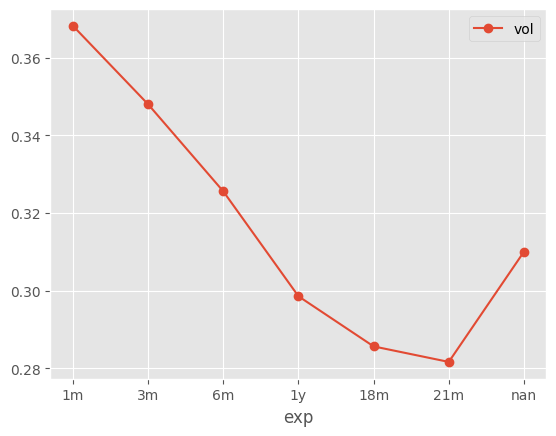

In [555]:
from pandas import Categorical
exp_vols = vols[vols.index.get_level_values('strike')==1.0]
exp_vols.reset_index(inplace=True)

exp_vols['exp'] = Categorical(exp_vols['exp'], categories=['1m', '3m', '6m', '1y', '18m', '21m'], ordered=True)
exp_vols.sort_values(by='exp', inplace=True)
exp_vols.plot(x='exp', y='vol', kind='line', marker='o')

## Heat Map Aggregate

In [27]:
from copy import deepcopy
# BASE_PRICING_CONFIG = deepcopy(PRICING_CONFIG)
chain_editable=deepcopy(chains)
from itertools import product
width_range = np.arange(0.5, 1, 0.1)
dte_range= np.arange(0, 70, 10)
combos=list(product(width_range, dte_range))

In [28]:
all_combos = []
for combo_choice in combos:
    meta={}
    _k_grid_editable = {}
    _t_grid_editable = {}
    _market_iv_grid_editable = {}
    _fwd_grid_editable = {}
    _atm_iv_editable = {}
    _atm_T_editable = {}
    # print(f"Testing combo: {combo_choice}")

    PRICING_CONFIG['VOL_SURFACE_WIDTH'] = combo_choice[0]
    PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD'] = combo_choice[1]
    meta['VOL_SURFACE_WIDTH'] = combo_choice[0]
    meta['VOL_SURFACE_MIN_DTE_THRESHOLD'] = combo_choice[1]
    meta['TICK_PARAMS'] = {}
    for tick in chain_editable:
        # if tick != 'AAPL' or combo_choice[1] != 0:
        #     continue
        print(f"Processing {tick} with combo {combo_choice}")
        chain_editable[tick] = confine_chain_with_pricing_config(chains[tick])
        print(f"Shape of chain_editable[{tick}]: {chain_editable[tick].shape}")
        chain_editable[tick]['vol'] = chain_editable[tick]['crr_vol_discrete']
        (var0_hat, var_inf_hat, kappa_hat), atm_loss = get_best_params(
            get_atm_T_maturities_on_chain(chain_editable[tick]),
            get_atm_T_vols_on_chain(chain_editable[tick])
        )
        params[tick] = {
            'var0_hat': var0_hat,
            'var_inf_hat': var_inf_hat,
            'kappa_hat': kappa_hat,
            'atm_loss': atm_loss
        }
        _k_grid_editable[tick] = get_K_grid(chain_editable[tick])
        _t_grid_editable[tick] = get_T_grid(chain_editable[tick])
        _market_iv_grid_editable[tick] = get_market_iv_grid(chain_editable[tick])
        _fwd_grid_editable[tick] = get_fwd_grid(chain_editable[tick])

        eta_hat, lambda_hat, rho_hat, best_loss = get_surface_params(
            get_K_grid(chain_editable[tick]),
            get_T_grid(chain_editable[tick]),
            get_fwd_grid(chain_editable[tick]),
            params[tick]['var0_hat'],
            params[tick]['var_inf_hat'],
            params[tick]['kappa_hat'],
            get_market_iv_grid(chain_editable[tick])
        )
        params[tick].update({
            'eta_hat': eta_hat,
            'lambda_hat': lambda_hat,
            'rho_hat': rho_hat,
            'surface_loss': best_loss
        })
        meta['TICK_PARAMS'][tick] = params[tick]
        print(f"Done for {tick} with combo {combo_choice}")
        print(f"Surface Loss for {tick}: {params[tick]['surface_loss']}")
    print(f"Done processing combo: {combo_choice}")
    all_combos.append({
        'meta': meta,
        'k_grid': _k_grid_editable,
        't_grid': _t_grid_editable,
        'market_iv_grid': _market_iv_grid_editable,
        'fwd_grid': _fwd_grid_editable
    })
    

Processing AAPL with combo (0.5, 0)
Shape of chain_editable[AAPL]: (1418, 22)
Done for AAPL with combo (0.5, 0)
Surface Loss for AAPL: 0.03263895401751859
Processing MSFT with combo (0.5, 0)
Shape of chain_editable[MSFT]: (2490, 22)
Done for MSFT with combo (0.5, 0)
Surface Loss for MSFT: 0.03174952801335476
Processing GOOGL with combo (0.5, 0)
Shape of chain_editable[GOOGL]: (1232, 22)
Done for GOOGL with combo (0.5, 0)
Surface Loss for GOOGL: 0.02549826077238575
Processing AMZN with combo (0.5, 0)
Shape of chain_editable[AMZN]: (1468, 22)
Done for AMZN with combo (0.5, 0)
Surface Loss for AMZN: 0.023943976939988225
Processing TSLA with combo (0.5, 0)
Shape of chain_editable[TSLA]: (2098, 22)
Done for TSLA with combo (0.5, 0)
Surface Loss for TSLA: 0.017454629714797484
Done processing combo: (0.5, 0)
Processing AAPL with combo (0.5, 10)
Shape of chain_editable[AAPL]: (1204, 22)
Done for AAPL with combo (0.5, 10)
Surface Loss for AAPL: 0.006238815762247019
Processing MSFT with combo (0

In [29]:
surface_meta_mean = []
for m in all_combos:
    data={}
    data['VOL_SURFACE_WIDTH'] = m['meta']['VOL_SURFACE_WIDTH']
    data['VOL_SURFACE_MIN_DTE_THRESHOLD'] = m['meta']['VOL_SURFACE_MIN_DTE_THRESHOLD']
    data['mean_surface_loss'] = np.mean(
        [v['surface_loss'] for v in m['meta']['TICK_PARAMS'].values()]
    )
    surface_meta_mean.append(data)    

error_df = pd.DataFrame(surface_meta_mean)
error_df

,VOL_SURFACE_WIDTH,VOL_SURFACE_MIN_DTE_THRESHOLD,mean_surface_loss
0,0.5,0,0.026257
1,0.5,10,0.005381
2,0.5,20,0.004007
3,0.5,30,0.003170
4,0.5,40,0.002146
5,0.5,50,0.001695
6,0.5,60,0.001695
7,0.6,0,0.037022
8,0.6,10,0.006848
9,0.6,20,0.005369


In [30]:
error_df.pivot_table(
    index="VOL_SURFACE_WIDTH", 
    columns="VOL_SURFACE_MIN_DTE_THRESHOLD", 
    values="mean_surface_loss", 
    aggfunc='sum'
)

VOL_SURFACE_MIN_DTE_THRESHOLD,0,10,20,30,40,50,60
VOL_SURFACE_WIDTH,,,,,,,
0.5,0.026257,0.005381,0.004007,0.003170,0.002146,0.001695,0.001695
0.6,0.037022,0.006848,0.005369,0.004506,0.002802,0.002288,0.002288
0.7,0.042242,0.007557,0.006201,0.005403,0.003571,0.003135,0.003135
0.8,0.043829,0.008377,0.006979,0.006166,0.004459,0.004000,0.004000
0.9,0.046104,0.010033,0.008603,0.007830,0.006261,0.005683,0.005683


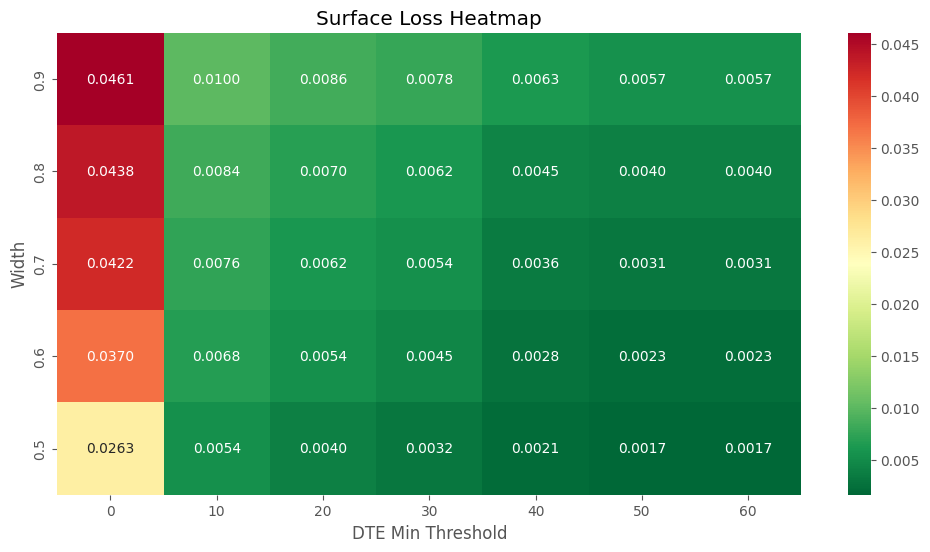

In [31]:

## Plot Heat Map
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# heatmap_data = error_df.pivot(index="width", columns="DTE_MIN_THRESHOLD",values="surface_loss")
heatmap_data = error_df.pivot_table(
    index="VOL_SURFACE_WIDTH", 
    columns="VOL_SURFACE_MIN_DTE_THRESHOLD", 
    values="mean_surface_loss", 
    aggfunc='mean'
)
heatmap_data.index = heatmap_data.index.round(2)
heatmap_data=heatmap_data.iloc[::-1]
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="RdYlGn_r")
plt.title("Surface Loss Heatmap")
plt.xlabel("DTE Min Threshold")
plt.ylabel("Width")
plt.show()

In [26]:
european_converted_chain

,root,expiration,strike,right,bid_size,closebid,ask_size,closeask,date,midpoint,...,bs_vol,intrinsic_value,eu_lower_bound,lower_bound,upper_bound,european_midpoint,american_midpoint,early_exercise_premium,european_equivalent_mid,european_vols_equiv
0,TSLA,2025-08-22,215.0,P,10,0.82,95,0.86,20250716,0.840,...,0.710251,0.000000,0.000000,0.000000,215.0,0.840168,0.834866,0.000000,0.840000,0.710251
1,TSLA,2025-08-22,215.0,C,21,107.85,18,109.50,20250716,108.675,...,0.744995,106.670013,107.589753,107.589753,215.0,108.675066,108.675043,0.000000,108.675000,0.744995
2,TSLA,2025-08-29,215.0,P,3,1.02,6,1.05,20250716,1.035,...,0.678131,0.000000,0.000000,0.000000,215.0,1.034915,1.037159,0.002244,1.032756,0.677882
3,TSLA,2025-08-29,215.0,C,26,108.00,31,110.35,20250716,109.175,...,0.720999,106.670013,107.763315,107.763315,215.0,109.174893,109.173417,0.000000,109.175000,0.720999
4,TSLA,2026-07-17,210.0,P,2,16.30,4,16.50,20250716,16.400,...,0.570025,0.000000,0.000000,0.000000,210.0,16.396771,16.633026,0.236254,16.163746,0.566651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737,TSLA,2025-07-18,215.0,P,60,0.01,145,0.02,20250716,0.015,...,1.832929,0.000000,0.000000,0.000000,215.0,0.015004,0.014670,0.000000,0.015000,1.832929
4738,TSLA,2025-08-01,215.0,C,1,106.80,18,108.35,20250716,107.575,...,0.985578,106.670013,107.068223,107.068223,215.0,107.575160,107.574173,0.000000,107.575000,0.985578
4739,TSLA,2025-08-01,215.0,P,120,0.33,28,0.35,20250716,0.340,...,0.926463,0.000000,0.000000,0.000000,215.0,0.340004,0.339081,0.000000,0.340000,0.926463
4740,TSLA,2025-08-15,215.0,C,6,108.00,7,108.55,20250716,108.275,...,0.790612,106.670013,107.416051,107.416051,215.0,108.275126,108.267384,0.000000,108.275000,0.790612


In [139]:
import numpy as np
import pandas as pd

# -------------------- American → European (de-Americanize) --------------------

def _eep_baw_or_bs2002(option_type: str, S: float, K: float, T: float,
                       r: float, q: float, sigma: float,
                       discrete_divs: list[tuple[float, float]] | None = None) -> float:
    """
    Estimate Early Exercise Premium (EEP) for an American vanilla option.
    Returns EEP >= 0 to subtract from the American price to get European price.
    TODO: Plug in your existing BAW or Bjerksund-Stensland implementation here.
    """
    # e.g., price_A = bjerksund_stensland_2002(...)
    #       price_E = black_scholes(...)
    #       return max(price_A - price_E, 0.0)
    raise NotImplementedError("Wire your BAW/BS2002 here")

def _invert_black_for_iv(option_type: str, S: float, K: float, T: float,
                         r: float, q: float, price_euro: float,
                         iv_init: float | None = None, tol: float = 1e-7, max_iter: int = 50) -> float:
    """
    Solve for Black-Scholes European IV given a target European price.
    Use your existing robust IV solver; this is just an interface shim.
    """
    # TODO: call your existing implied vol solver
    raise NotImplementedError("Connect to your IV solver here")

def de_americanize_quotes(df: pd.DataFrame,
                          r: float, q: float,
                          discrete_divs: list[tuple[float, float]] | None = None,
                          eep_iters: int = 2) -> pd.DataFrame:
    """
    Convert American mid prices to European-equivalent IVs by iterating:
    1) start with df['mid_iv'] (or a seed) as sigma
    2) estimate EEP with BAW/BS2002
    3) price_E = price_A - EEP
    4) invert for sigma_E (European IV)
    A couple iterations are usually plenty.
    Expects columns: ['right','S','strike','t','mid_price','mid_iv']
    Returns: new column 'euro_iv'
    """
    out = df.copy()
    # seed: use current iv if present
    if 'mid_iv' in out:
        out['euro_iv'] = pd.to_numeric(out['mid_iv'], errors='coerce')
    else:
        out['euro_iv'] = np.nan

    for _ in range(eep_iters):
        next_iv = []
        for _, row in out.iterrows():
            right = str(row['right']).upper()[0]
            S  = float(row['S']);    K = float(row['strike'])
            T  = float(row['t']);    Pm = float(row['mid_price'])
            iv = float(row['euro_iv']) if np.isfinite(row['euro_iv']) else 0.20  # fallback seed

            # EEP estimate (depends on IV)
            eep = _eep_baw_or_bs2002(right, S, K, T, r, q, iv, discrete_divs)
            price_euro = max(Pm - eep, 0.0)

            # invert to new IV_E
            iv_e = _invert_black_for_iv(right, S, K, T, r, q, price_euro, iv_init=iv)
            next_iv.append(iv_e)
        out['euro_iv'] = next_iv
    return out

# -------------------- D(T) via box spreads; F(T) via parity -------------------

def _compute_discount_from_box(expiry_df: pd.DataFrame) -> float:
    """
    Estimate D(T) using box spreads:
    D ≈ ((C(K1)-C(K2)) - (P(K1)-P(K2))) / (K2 - K1), averaged over pairs.
    Expects: euro call/put prices in columns ['call_euro_price','put_euro_price'] at same expiry.
    """
    df = expiry_df.dropna(subset=['strike','call_euro_price','put_euro_price']).sort_values('strike')
    Ks = df['strike'].to_numpy()
    C  = df['call_euro_price'].to_numpy()
    P  = df['put_euro_price'].to_numpy()

    Ds = []
    for i in range(len(Ks) - 1):
        K1, K2 = Ks[i], Ks[i+1]
        C1, C2 = C[i], C[i+1]
        P1, P2 = P[i], P[i+1]
        denom = (K2 - K1)
        if denom > 0:
            Ds.append(((C1 - C2) - (P1 - P2)) / denom)
    Ds = np.array([d for d in Ds if np.isfinite(d) and d > 0])
    if len(Ds) == 0:
        raise ValueError("Could not infer discount factor from box spreads at this expiry.")
    # robust location
    return float(np.median(np.clip(Ds, 1e-6, 1.0)))

def _vega_spread_weights(df: pd.DataFrame) -> np.ndarray:
    """
    w = vega / (1 + rel_spread), clipped to avoid extremes.
    Expects 'vega' and optional 'rel_spread'.
    """
    vega = pd.to_numeric(df['vega'], errors='coerce').fillna(0.0).to_numpy()
    rs   = pd.to_numeric(df.get('rel_spread', np.nan), errors='coerce').to_numpy()
    rs   = np.where(np.isfinite(rs) & (rs > 0), rs, 0.0)
    w    = vega / (1.0 + rs)
    return np.where(np.isfinite(w), np.clip(w, 0.0, np.nanpercentile(w, 95)), 0.0)

def infer_forward_from_parity(expiry_df: pd.DataFrame, D: float) -> float:
    """
    With Europeanized prices and discount D(T), get per-strike F_i = K + (C - P)/D,
    then return a robust, weighted estimator F*.
    Expects: columns ['strike','call_euro_price','put_euro_price','vega','rel_spread'].
    """
    K = pd.to_numeric(expiry_df['strike'], errors='coerce').to_numpy()
    C = pd.to_numeric(expiry_df['call_euro_price'], errors='coerce').to_numpy()
    P = pd.to_numeric(expiry_df['put_euro_price'], errors='coerce').to_numpy()
    Fi = K + (C - P) / max(D, 1e-8)

    w  = _vega_spread_weights(expiry_df)
    mask = np.isfinite(Fi) & (w > 0)
    if mask.sum() < 3:
        return float(np.nanmedian(Fi))

    # trimmed, weighted median
    Fi, w = Fi[mask], w[mask] ## Keep finite values
    lo, hi = np.nanpercentile(Fi, [10, 90]) ## Filter out extremes
    keep   = (Fi >= lo) & (Fi <= hi) ## Extreme filtered mask
    Fi, w  = Fi[keep], w[keep] ## Apply mask
    # weighted median
    order = np.argsort(Fi) ## Produce sorted indices for Implied Forward.
    Fi, w = Fi[order], w[order] ## Reorder by Implied Forward
    csum = np.cumsum(w) / np.sum(w) ## Cumsum to get cumulative weights
    j = np.searchsorted(csum, 0.5) ## Pick the index where cumulative weight crosses 0.5
    return float(Fi[min(j, len(Fi)-1)])

def recompute_log_moneyness(df: pd.DataFrame, F_star: float) -> pd.DataFrame:
    out = df.copy()
    out['log_moneyness'] = np.log(pd.to_numeric(out['strike'], errors='coerce') / float(F_star))
    return out


In [62]:
# np.nanpercentile(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), [10, 90])
np.argsort(np.array([1, 2, 3, 4, 5, 6, 7, 8, 11, 10])) # [0 1 2 3 4 5 6 7 8 9]
np.searchsorted?

Signature: np.searchsorted(a, v, side='left', sorter=None)
Docstring:
Find indices where elements should be inserted to maintain order.

Find the indices into a sorted array `a` such that, if the
corresponding elements in `v` were inserted before the indices, the
order of `a` would be preserved.

Assuming that `a` is sorted:

======  ============================
`side`  returned index `i` satisfies
======  ============================
left    ``a[i-1] < v <= a[i]``
right   ``a[i-1] <= v < a[i]``
======  ============================

Parameters
----------
a : 1-D array_like
    Input array. If `sorter` is None, then it must be sorted in
    ascending order, otherwise `sorter` must be an array of indices
    that sort it.
v : array_like
    Values to insert into `a`.
side : {'left', 'right'}, optional
    If 'left', the index of the first suitable location found is given.
    If 'right', return the last such index.  If there is no suitable
    index, return either 0 or N (where N is the 

In [119]:
r = get_rates(european_converted_chain['valuation_date'].iloc[0])
european_converted_chain.columns

Index(['root', 'expiration', 'strike', 'right', 'bid_size', 'closebid',
       'ask_size', 'closeask', 'date', 'midpoint', 'weighted_midpoint', 'spot',
       'valuation_date', 'moneyness', 'log_moneyness', 't', 'dte', 'f',
       'f_moneyness', 'f_log_moneyness', 'div_schedule', 'bs_vol',
       'intrinsic_value', 'eu_lower_bound', 'lower_bound', 'upper_bound',
       'european_midpoint', 'american_midpoint', 'early_exercise_premium',
       'european_equivalent_mid', 'european_vols_equiv', 'vega'],
      dtype='object')

In [45]:
chain_for_box.expiration.unique()

<DatetimeArray>
['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
 '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
 '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
 '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
 '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-07-17 00:00:00', '2026-09-18 00:00:00',
 '2026-12-18 00:00:00', '2027-01-15 00:00:00', '2027-06-17 00:00:00',
 '2027-12-17 00:00:00']
Length: 22, dtype: datetime64[ns]

In [67]:
vectorized_black_scholes_greeks?

Signature:
vectorized_black_scholes_greeks(
    F: List[str],
    S: List[float],
    K: List[float],
    valuation_dates: List[datetime.datetime],
    end_dates: List[datetime.datetime],
    r: List[float],
    sigma: List[float],
    option_type: Union[str, List[str]] = 'c',
    div_type='discrete',
    div_amount=None,
) -> dict
Docstring:
Vectorized Black-Scholes Greeks calculation.
F: Forward prices (array)
S: Spot prices (array)
K: Strike prices (array)
valuation_dates: List of valuation dates (dates for which the option is priced)
end_dates: List of end dates (expiration dates of the options)
r: Risk-free rates (annualized, array)
sigma: Volatilities (annualized, array)
option_type: "c" for call, "p" for put (single string or list of strings)
div_type: Type of dividend ('discrete' or 'continuous')
div_amount: Dividend amount (single float or list of floats, ignored for continuous dividends)
Returns: Greeks (dictionary)
File:      ~/cloned_repos/QuantTools/module_test/raw_code/op

In [242]:
div_pv = vectorized_discrete_pv(
    european_converted_chain['div_schedule'].values,
    r = [get_rates(european_converted_chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(european_converted_chain),
    _valuation_dates= european_converted_chain['valuation_date'].values,
    _end_dates= european_converted_chain['expiration'].values
)
greeks = vectorized_black_scholes_greeks(
    F=european_converted_chain['f'].values,
    S= european_converted_chain['spot'].values,
    K= european_converted_chain['strike'].values,
    valuation_dates= european_converted_chain['valuation_date'].values,
    end_dates= european_converted_chain['expiration'].values,
    r= [get_rates(european_converted_chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(european_converted_chain),
    sigma = european_converted_chain['european_vols_equiv'].values,
    option_type= european_converted_chain['right'].str.lower().values,
    div_type='discrete',
    div_amount= div_pv
)

In [244]:
european_converted_chain['vega'] = greeks['vega']
# european_converted_chain['rel_c'] = greeks['']

<Axes: xlabel='expiration'>

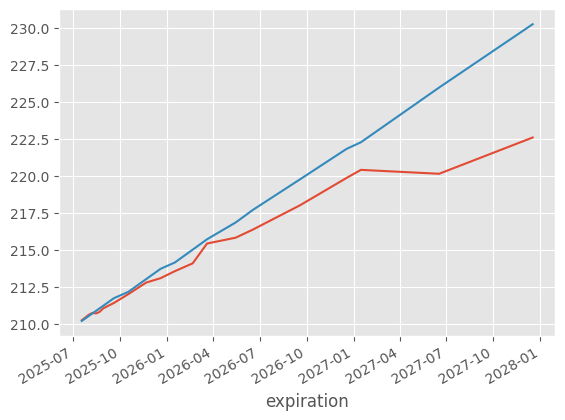

In [259]:
# _compute_discount_from_box(european_converted_chain,
#                            )

chain_for_box = european_converted_chain.pivot_table(
    index = ['expiration', 'strike', 'valuation_date',],
    columns = 'right',
    values = ['midpoint', 'closebid', 'closeask', 'vega']
).reset_index()
chain_for_box.columns = chain_for_box.columns.map(lambda x: f"{x[0]}_{x[1]}" if x[1] != '' else x[0])
chain_for_box['call_euro_price'] = chain_for_box['midpoint_C']
chain_for_box['put_euro_price'] = chain_for_box['midpoint_P']
chain_for_box.drop(columns=['midpoint_C', 'midpoint_P'], inplace=True)
chain_for_box['rel_spread_c'] = (
    chain_for_box['closeask_C'] - chain_for_box['closebid_C']
) / chain_for_box['call_euro_price']

chain_for_box['rel_spread_p'] = (
    chain_for_box['closeask_P'] - chain_for_box['closebid_P']
) / chain_for_box['put_euro_price']

chain_for_box['vega'] = chain_for_box.apply(lambda x: min(x['vega_C'], x['vega_P']), axis=1)
chain_for_box['rel_spread'] = chain_for_box.apply(
    lambda x: min(x['rel_spread_c'], x['rel_spread_p']), axis=1
)


# chain_for_box.expiration.unique()

D_by_exp = chain_for_box.groupby('expiration').apply(
    lambda df: _compute_discount_from_box(df)
)

F_by_exp = chain_for_box.groupby('expiration').apply(
    lambda df: infer_forward_from_parity(df, D=D_by_exp[df['expiration'].iloc[0]])
)

T_by_exp = chain_for_box.groupby('expiration').apply(
    lambda df: time_distance_helper(
        df['expiration'].iloc[0], df['valuation_date'].iloc[0]
    )
)

implied_discount_premium = r +( np.log(D_by_exp) / T_by_exp)

mkt_f_by_exp = european_converted_chain.groupby('expiration').f.last()
implied_discount_premium
F_by_exp.plot()
mkt_f_by_exp.plot()


<Axes: xlabel='expiration'>

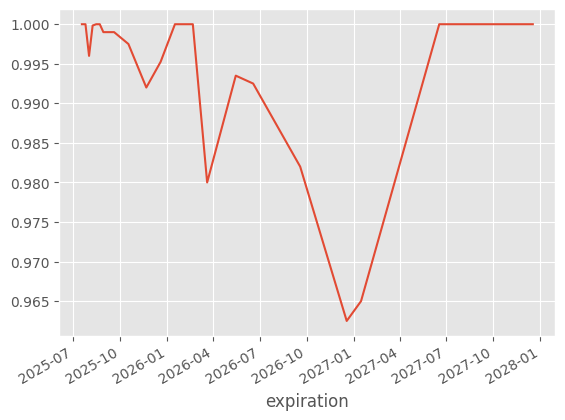

In [260]:
D_by_exp.plot()

In [246]:
get_bs_vol_on_chain?

Signature:
get_bs_vol_on_chain(
    chain: pandas.core.frame.DataFrame,
    valuation_date: str,
) -> pandas.core.series.Series
Docstring:
Estimates the Black-Scholes implied volatility for a given option chain.

Args:
    chain (pd.DataFrame): The option chain DataFrame.
        Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
    valuation_date (str): The date of valuation.
    
Returns:
    pd.Series: The estimated Black-Scholes implied volatility for the option chain.
File:      /var/folders/j0/80hkbygd4lb27h9mw76gqzpw0000gn/T/ipykernel_37786/2020857283.py
Type:      function

In [247]:
tester=chain_for_box.set_index(['expiration'])
tester['f'] = F_by_exp
tester['t'] = T_by_exp
tester = tester.reset_index().melt(
    id_vars = ['expiration', 'strike', 'valuation_date', 'f', 't'],
    value_vars = ['call_euro_price', 'put_euro_price'],
    value_name = 'midpoint'
).dropna().reset_index(drop=True)   
tester['right'] = tester['variable'].str.split('_').str[0].str[0].str.upper()
tester['equalized_iv']=get_bs_vol_on_chain(
    tester,
    valuation_date=tester['valuation_date'].iloc[0],
)
tester

,expiration,strike,valuation_date,f,t,variable,midpoint,right,equalized_iv
0,2025-07-18,110.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,100.375000,C,3.747594
1,2025-07-18,115.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,95.475000,C,3.776839
2,2025-07-18,120.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,90.475000,C,3.533382
3,2025-07-18,130.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,80.475000,C,3.074212
4,2025-07-18,135.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,75.400000,C,2.702652
...,...,...,...,...,...,...,...,...,...
2019,2027-12-17,420.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,194.528686,P,0.452546
2020,2027-12-17,425.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,199.261261,P,0.458920
2021,2027-12-17,430.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,203.994795,P,0.465294
2022,2027-12-17,435.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,208.727394,P,0.471543


In [248]:
tester.expiration.unique()

<DatetimeArray>
['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
 '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
 '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
 '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
 '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-09-18 00:00:00', '2026-12-18 00:00:00',
 '2027-01-15 00:00:00', '2027-06-17 00:00:00', '2027-12-17 00:00:00']
Length: 21, dtype: datetime64[ns]

In [249]:
tester.dropna()

,expiration,strike,valuation_date,f,t,variable,midpoint,right,equalized_iv
0,2025-07-18,110.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,100.375000,C,3.747594
1,2025-07-18,115.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,95.475000,C,3.776839
2,2025-07-18,120.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,90.475000,C,3.533382
3,2025-07-18,130.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,80.475000,C,3.074212
4,2025-07-18,135.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,75.400000,C,2.702652
...,...,...,...,...,...,...,...,...,...
2019,2027-12-17,420.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,194.528686,P,0.452546
2020,2027-12-17,425.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,199.261261,P,0.458920
2021,2027-12-17,430.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,203.994795,P,0.465294
2022,2027-12-17,435.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,208.727394,P,0.471543


<Axes: title={'center': 'Implied Volatility Surface for 2027-12-17 Expiration'}, xlabel='Strike Price', ylabel='Implied Volatility'>

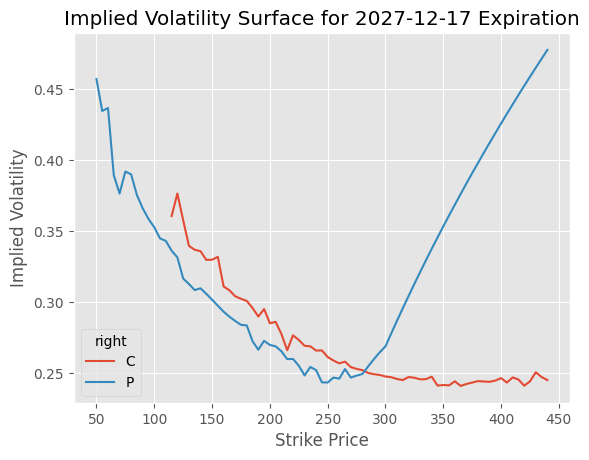

In [264]:
tester[tester.expiration == exp].pivot_table(
    columns='right',
    index='strike',
    values='equalized_iv'
).plot(
    kind='line',
    title='Implied Volatility Surface for 2027-12-17 Expiration',
    ylabel='Implied Volatility',
    xlabel='Strike Price'
)